# 01.00-maj-explore-databases
Mitchell Joseph
<br>Created: 2022-11-13</br>
Last Modified: 2022-11-13

We have three databases,
- [`HIGH SCHOOL.db` (16.4GB)](#high-school)
- [`DEMOGRAPHICS.db` (10.2GB)](#demographics)
- [`TFS_CHOICE_2008_2010.db` (2.26GB)](#tfs-choice)

In this notebook we'll begin by exploring these databases to get a better understanding of our data.

In [1]:
import sqlite3
import os
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import plotly.express as px

import stan
import nest_asyncio
nest_asyncio.apply()
import arviz

In [10]:
def run_query(db_path, query):
    """Query a database and return a pandas DataFrame."""
    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

def clean_data(df):
    """Clean the data by removing missing values from the dataset."""
    df_filled = df.fillna(value=np.nan)
    print("Raw Data")
    msno.matrix(df_filled.sample(500))

    df_non_empty_cols = remove_missing_columns(df_filled)
    print("Columns Filtered")
    msno.matrix(df_non_empty_cols.sample(500))

    df_non_empty_rows = remove_missing_rows(df_non_empty_cols)
    print("Rows filtered")
    msno.matrix(df_non_empty_rows.sample(500));
    return df_non_empty_rows

def remove_missing_columns(df, threshold=0.05):
    """Remove columns that have > 5% missing values."""
    n_rows = df.shape[0]
    non_empty_cols = []
    for col in df.columns:
        if df[col].isna().sum() / n_rows < threshold:
            non_empty_cols.append(col)
    return df[non_empty_cols].copy()

def remove_missing_rows(df):
    """Remove rows that have > 5% missing values."""
    n_cols = df.shape[1]
    non_empty_rows = []
    for row in range(len(df)):
        if df.iloc[row, :].isna().sum() / n_cols < 0.05:
            non_empty_rows.append(row)
    return df.iloc[non_empty_rows, :].copy()

## High School

In [3]:
db_path = "../data/00-external/HIGH_SCHOOL.db"

Now let's look at just the year 2010

In [4]:
query_2010 = """
SELECT * FROM 'HIGH SCHOOL'
WHERE Surveyyear == 2010;
"""

hs_df_raw = run_query(db_path, query_2010)

In [5]:
hs_df_raw.shape

(262433, 395)

In [6]:
# Data preprocessing
hs_df_raw.replace(
    {'Highest 10%':5,
     'Above average':4,
     'Average':3,
     'Below average':2,
     'Lowest 10%':1},
     inplace=True)

hs_df_raw.replace({'Five or more':5,
                    'Four':4,
                    'Three':3,
                    'Two':2,
                    'One':1,
                    'Less than one':0,
                    'None':0}, inplace=True)

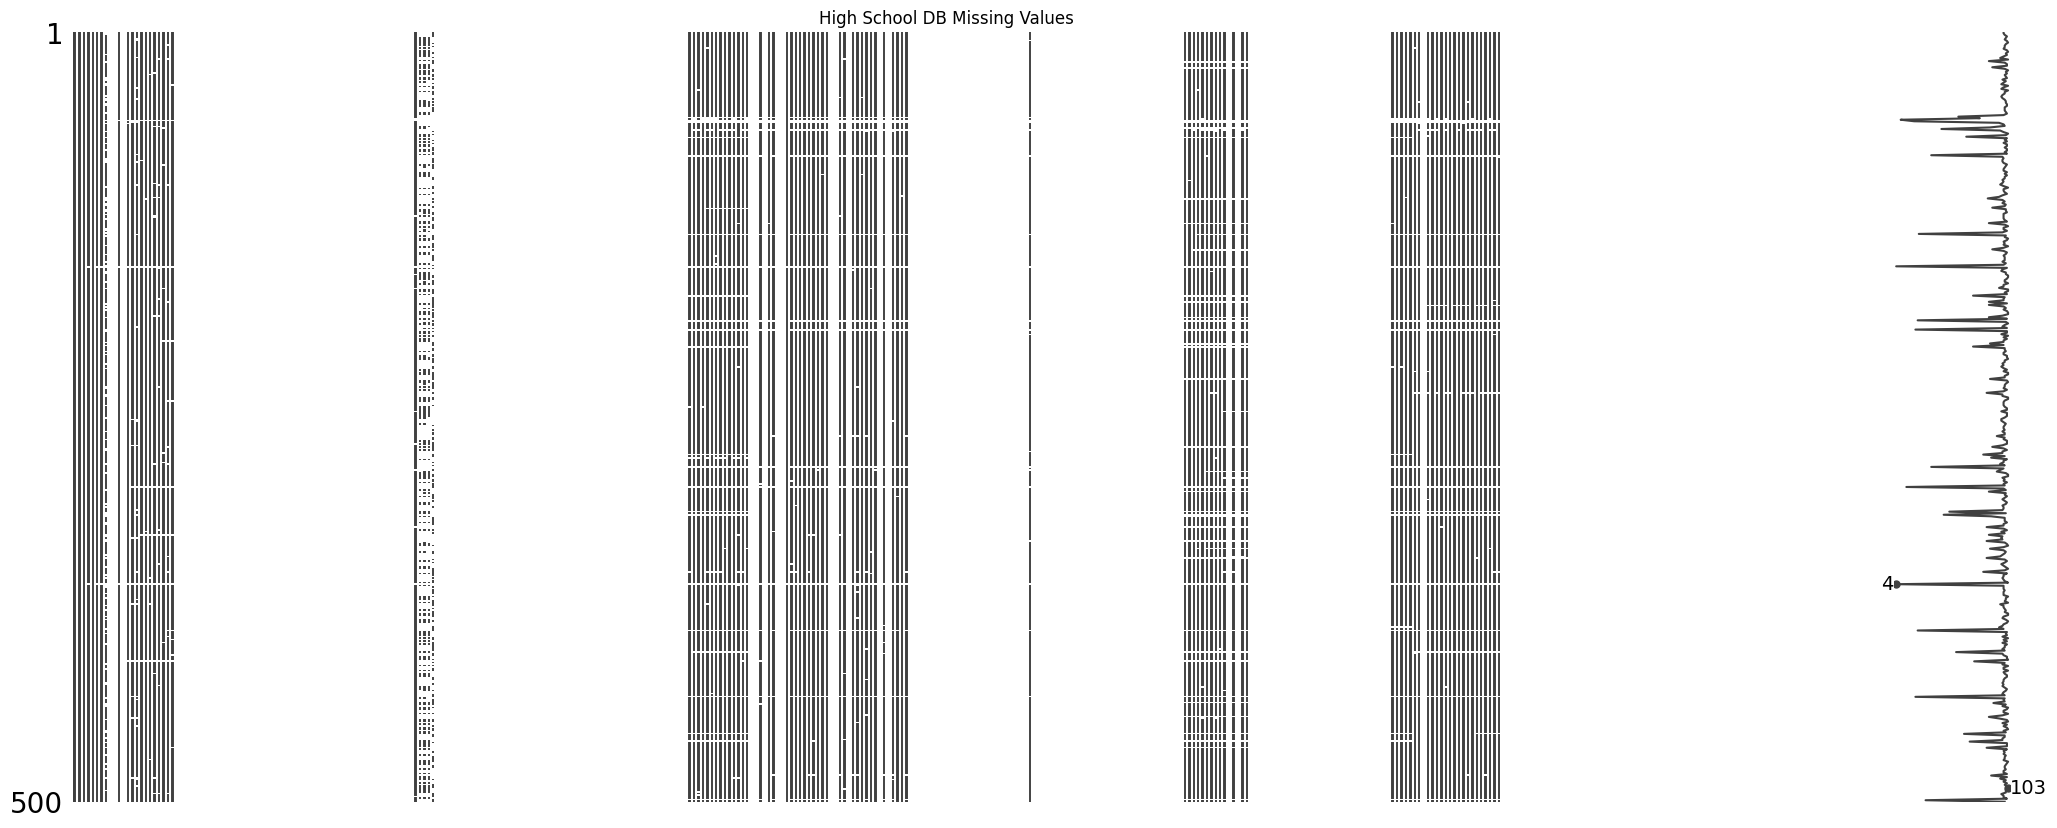

In [9]:
# Raw Data
hs_df_raw_filled = hs_df_raw.fillna(value=np.nan)
msno.matrix(hs_df_raw_filled.sample(500))
plt.title("High School DB Missing Values")
plt.savefig("../stats/high_school_db_msno.png");

There's a lot of columns with no data so let's remove those and see what we have left.

In [11]:
hs_df_nmis = remove_missing_columns(hs_df_raw_filled)

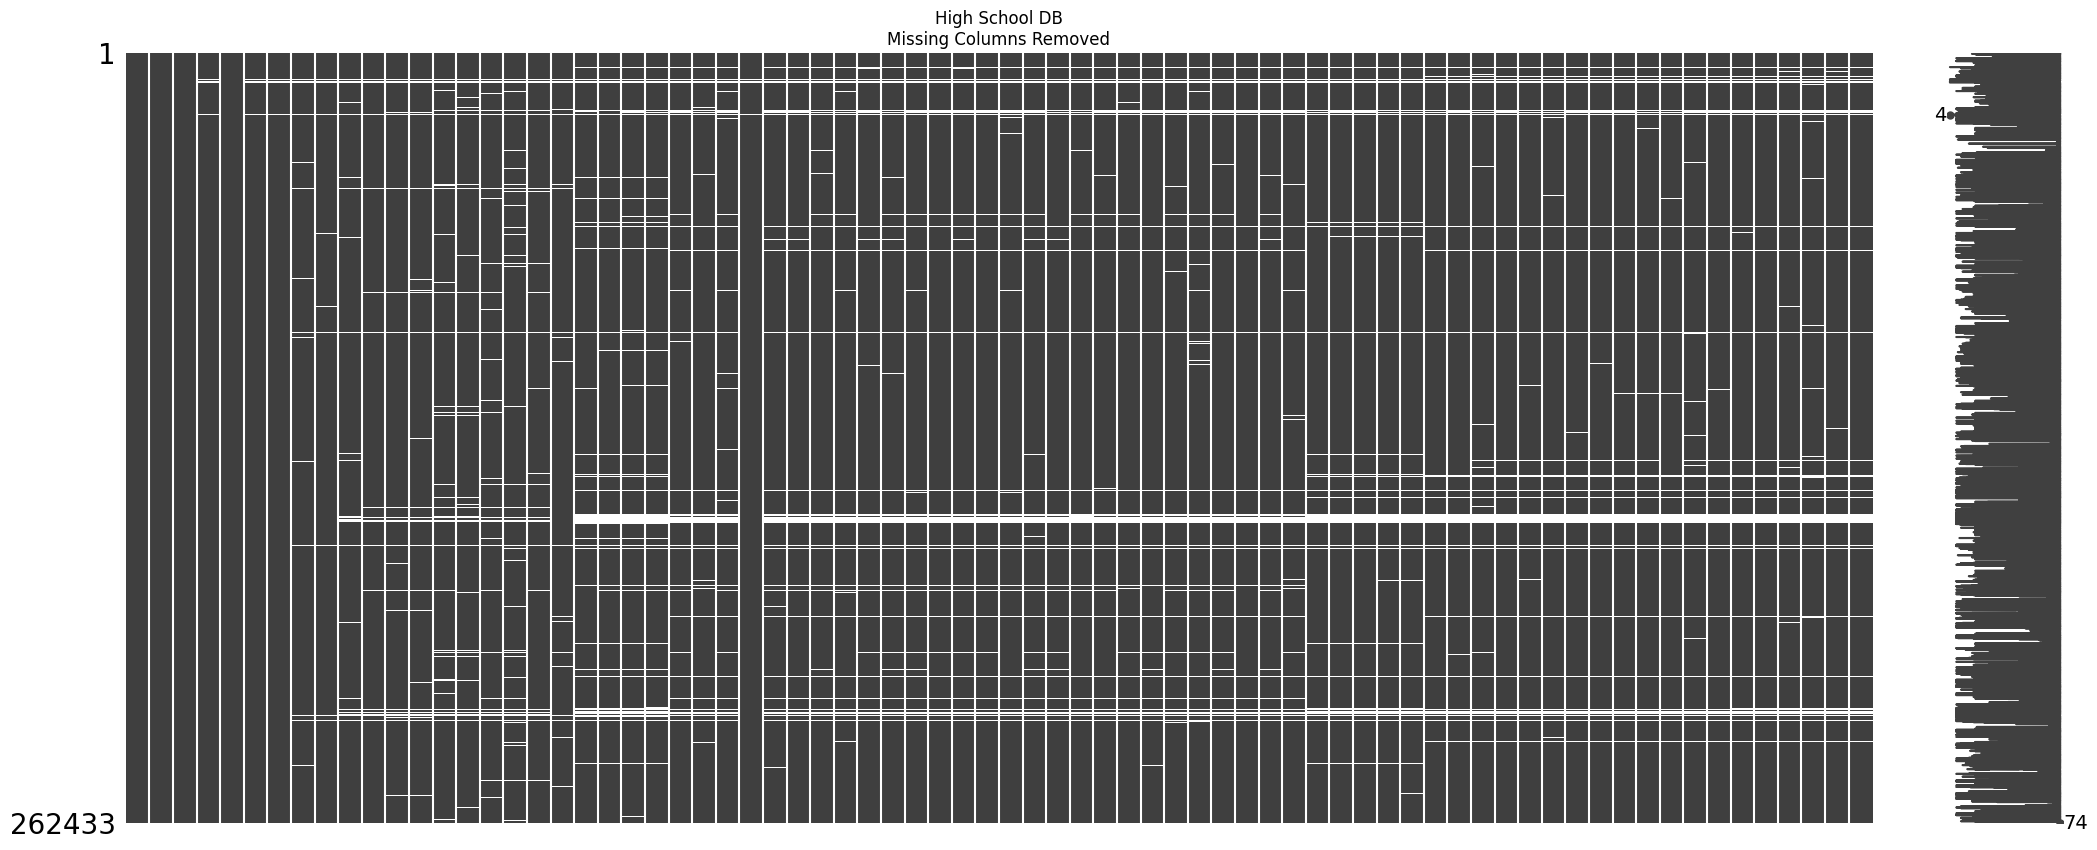

In [13]:
# View data with bad columns removed
msno.matrix(hs_df_nmis)
plt.title("High School DB\nMissing Columns Removed")
plt.savefig("../stats/high_school_db_cols_removed_msno.png")

In [22]:
print(f"GPA : {set(hs_df_nmis['Whatwasyouraveragegradeinhighschool?'])}")
print(f"Habits : {set(hs_df_nmis['HabitsofMind:Reviseyourpaperstoimproveyourwriting'])}")
print(f"Action : {set(hs_df_nmis['ActinPastYear:Askedateacherforadviceafterclass'])}")

GPA : {'C+', nan, 'B', 'B+', 'C', 'D', 'A or A+', 'B-', 'A-'}
Habits : {'Frequently', nan, 'Occasionally', 'Not at all'}
Action : {'Frequently', nan, 'Occasionally', 'Not at all'}


In [14]:
list(hs_df_nmis.columns)

['Surveyyear',
 'RecodedCollegeI.D.',
 'SubjectI.D.',
 'OBERegion',
 'CIRPStratificationCell',
 'Studentstatus',
 'Normsstatus',
 'Fromwhatkindofhighschooldidyougraduate?',
 'Inwhatyeardidyougraduatefromhighschool?',
 'Howwouldyoudescribetheracialcompositionofthehighschoolyoulastattended?',
 'YearsStudy:English',
 'YearsStudy:Mathematics',
 'YearsStudy:ForeignLanguage',
 'YearsStudy:PhysicalScience',
 'YearsStudy:BiologicalScience',
 'YearsStudy:History/AmGovt',
 'YearsStudy:ComputerScience',
 'YearsStudy:Artand/orMusic',
 'Whatwasyouraveragegradeinhighschool?',
 'HabitsofMind:Askquestionsinclass',
 'HabitsofMind:Supportyouropinionswithalogicalargument',
 'HabitsofMind:Seeksolutionstoproblemsandexplainthemtoothers',
 'HabitsofMind:Reviseyourpaperstoimproveyourwriting',
 'ActinPastYear:Askedateacherforadviceafterclass',
 'ActinPastYear:Attendedareligiousservice',
 'ActinPastYear:Beenlatetoclass',
 'ActinPastYear:Demonstratedforacause(e.g.boycottrallyprotest)',
 'ActinPastYear:Discussedp

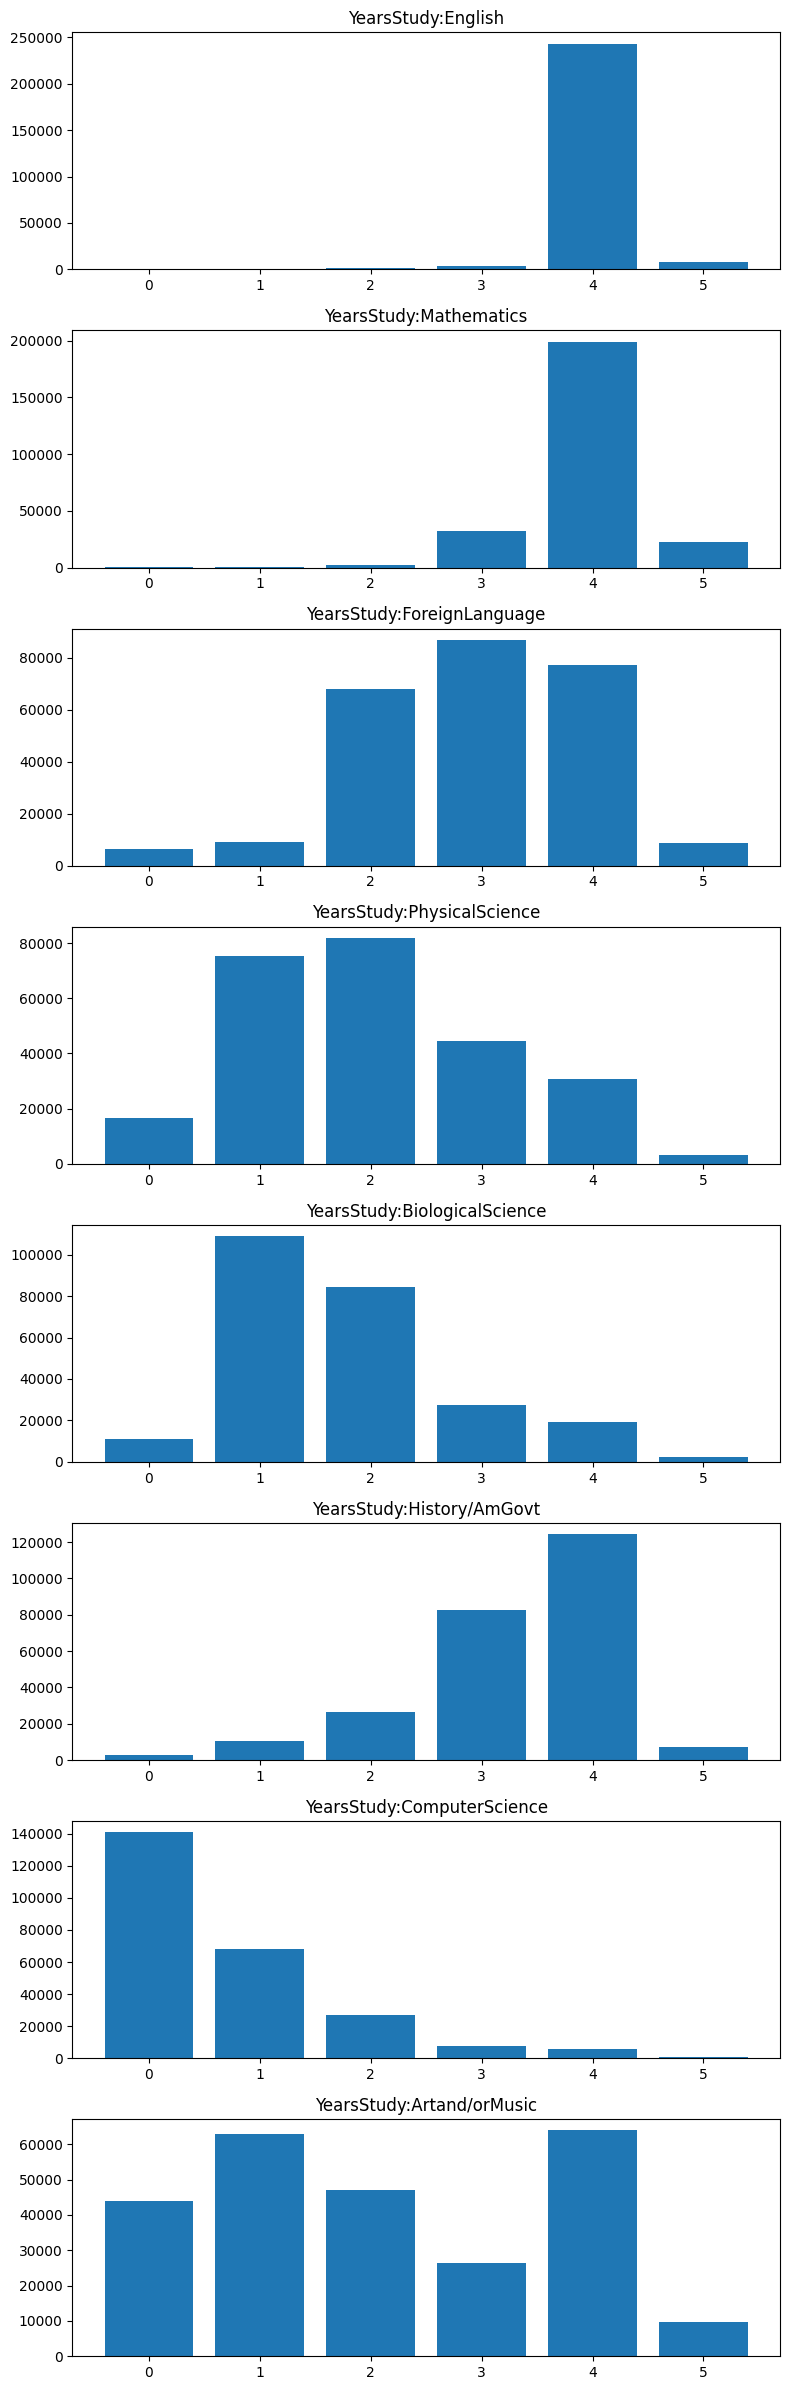

In [45]:
plt_idx = 0
fig, ax = plt.subplots(8,1, figsize=(8, 3*8))
for col in hs_df_nmis.columns:
    if 'YearsStudy' in col:
        plt.sca(ax[plt_idx])
        x = hs_df_nmis[col].value_counts().index
        y = hs_df_nmis[col].value_counts().values
        plt.title(col)
        plt.bar(x, y, label=col)
        plt_idx += 1
plt.tight_layout()
plt.show();

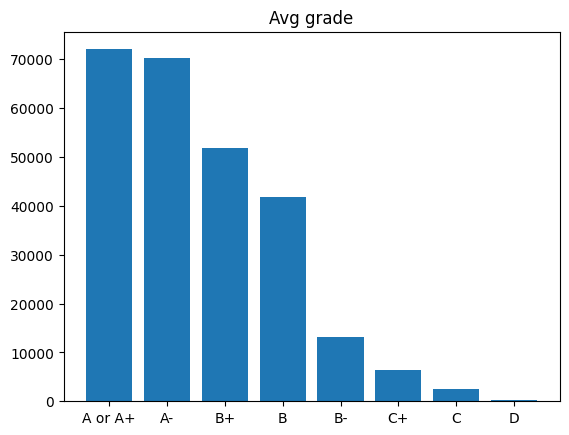

In [46]:
x = hs_df_nmis['Whatwasyouraveragegradeinhighschool?'].value_counts().index
y = hs_df_nmis['Whatwasyouraveragegradeinhighschool?'].value_counts().values

plt.title('Avg grade')
plt.bar(x, y)
plt.show();

Since most students are either A or B, I don't think we'll be able to get miuch information out of this. 

In [47]:
hs_df_nmis[['YearsStudy:Mathematics', 'SelfRating:Mathematicalability']].corr()

,YearsStudy:Mathematics,SelfRating:Mathematicalability
YearsStudy:Mathematics,1.000000,0.240176
SelfRating:Mathematicalability,0.240176,1.000000


How are all the self reported metrics related?

In [48]:
fig = px.imshow(hs_df_nmis[[
            'SelfRating:Academicability',
            'SelfRating:Artisticability',
            'SelfRating:Competitiveness',
            'SelfRating:Computerskills',
            'SelfRating:Cooperativeness',
            'SelfRating:Creativity',
            'SelfRating:Drivetoachieve',
            'SelfRating:Emotionalhealth',
            'SelfRating:Leadershipability',
            'SelfRating:Mathematicalability',
            'SelfRating:Physicalhealth',
            'SelfRating:Popularity',
            'SelfRating:Publicspeakingability',
            'SelfRating:Self-confidence(intellectual)',
            'SelfRating:Self-confidence(social)',
            'SelfRating:Self-understanding',
            'SelfRating:Spirituality',
            'SelfRating:Understandingofothers',
            'SelfRating:Writingability']].corr())
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.show();

Interesting correlations:
- Artistic/Creativity 0.54
- public speaking/leadership 0.53
- self confidence (social)/popularity 0.56
- self confidence(social)/self confidence(intellectual) 0.55
- self confidence(intellectual) / understanding 0.50

In [49]:
print(f"Percent SAT Verbal missing: {hs_df_raw['SATVerbal'].isna().sum() / len(hs_df_raw)}")
print(f"Percent SAT Math missing: {hs_df_raw['SATMath'].isna().sum() / len(hs_df_raw)}")
print(f"Percent SAT Writing missing: {hs_df_raw['SATWriting'].isna().sum() / len(hs_df_raw)}")
print(f"Percent ACT Composite missing: {hs_df_raw['ACTComposite'].isna().sum() / len(hs_df_raw)}")

Percent SAT Verbal missing: 0.5872127362031452
Percent SAT Math missing: 0.5650165947117931
Percent SAT Writing missing: 0.5856694851638323
Percent ACT Composite missing: 0.5327416902599902


We're missing about 50% of the data for SAT/ACT scores. 

Let's see if we can impute these values by building a simple linear regression model in stan.

In [71]:
verbal_code = """
data {
    int N_obs;
    int k;
    matrix[N_obs, k] X_obs;
    vector<lower=200, upper=600>[N_obs] Y_obs;

    int do_prior_predictive;
}
parameters {
    vector[N_obs] alpha;
    vector[k] beta;
    real <lower=0> sigma;
}
transformed parameters {
    vector[N_obs] mu;
    mu = alpha + X_obs * beta;
}
model {
    beta ~ normal(0, 50);
    sigma ~ lognormal(0, 1);

    if (do_prior_predictive != 1) {
        Y_obs ~ normal(mu, sigma);
    }
}
generated quantities {
    array[N_obs] real<lower=200,upper=600> Y_tilde;
    Y_tilde = normal_rng(mu, sigma);
}
"""

In [88]:
target = 'SATVerbal'
select_cols = [
    target,
    'YearsStudy:English',
    # 'YearsStudy:Mathematics',
    # 'YearsStudy:ForeignLanguage',
    # 'YearsStudy:PhysicalScience',
    # 'YearsStudy:BiologicalScience',
    # 'YearsStudy:History/AmGovt',
    # 'YearsStudy:ComputerScience',
    # 'YearsStudy:Artand/orMusic',
    # 'SelfRating:Academicability',
    # 'SelfRating:Artisticability',
    # 'SelfRating:Competitiveness',
    # 'SelfRating:Computerskills',
    # 'SelfRating:Cooperativeness',
    # 'SelfRating:Creativity',
    # 'SelfRating:Drivetoachieve',
    # 'SelfRating:Emotionalhealth',
    # 'SelfRating:Leadershipability',
    # 'SelfRating:Mathematicalability',
    # 'SelfRating:Physicalhealth',
    # 'SelfRating:Popularity',
    # 'SelfRating:Publicspeakingability',
    # 'SelfRating:Self-confidence(intellectual)',
    # 'SelfRating:Self-confidence(social)',
    # 'SelfRating:Self-understanding',
    # 'SelfRating:Spirituality',
    # 'SelfRating:Understandingofothers',
    'SelfRating:Writingability']

model_data = hs_df_raw[select_cols].dropna().copy()
N_obs = model_data.shape[0]
Y = model_data[target].to_numpy()
X = model_data.drop(target, axis=1)
X = np.concatenate([np.ones((N_obs, 1)), X.to_numpy()], axis=1)
X = X.astype(np.int8)
k = X.shape[1]

In [89]:
SATVerbal_model = stan.build(verbal_code, {
    'N_obs':N_obs,
    'k':k,
    'X_obs':X,
    'Y_obs':Y,
    'do_prior_predictive': 1
})

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_f5jamr5q/model_zw24m723.stan', line 20, column 21: Argument
    50 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


KeyError: 'message'

Are the following equivalent?
- 'HowmanyAdvancedPlacementcoursesdidyoutakeinhighschool?'
- 'HowmanyAPcoursesdidyoutakeinhighschool?'
- 'APCourses'

In [25]:
hs_df_raw[['SATVerbal', 'SATMath', 'SATWriting']].fillna(value=np.nan).dropna().describe()

,SATVerbal,SATMath,SATWriting
count,104077,104077,104077
unique,397,411,428
top,600,600,600
freq,5387,4896,5847


Raw Data
Columns Filtered
Rows filtered


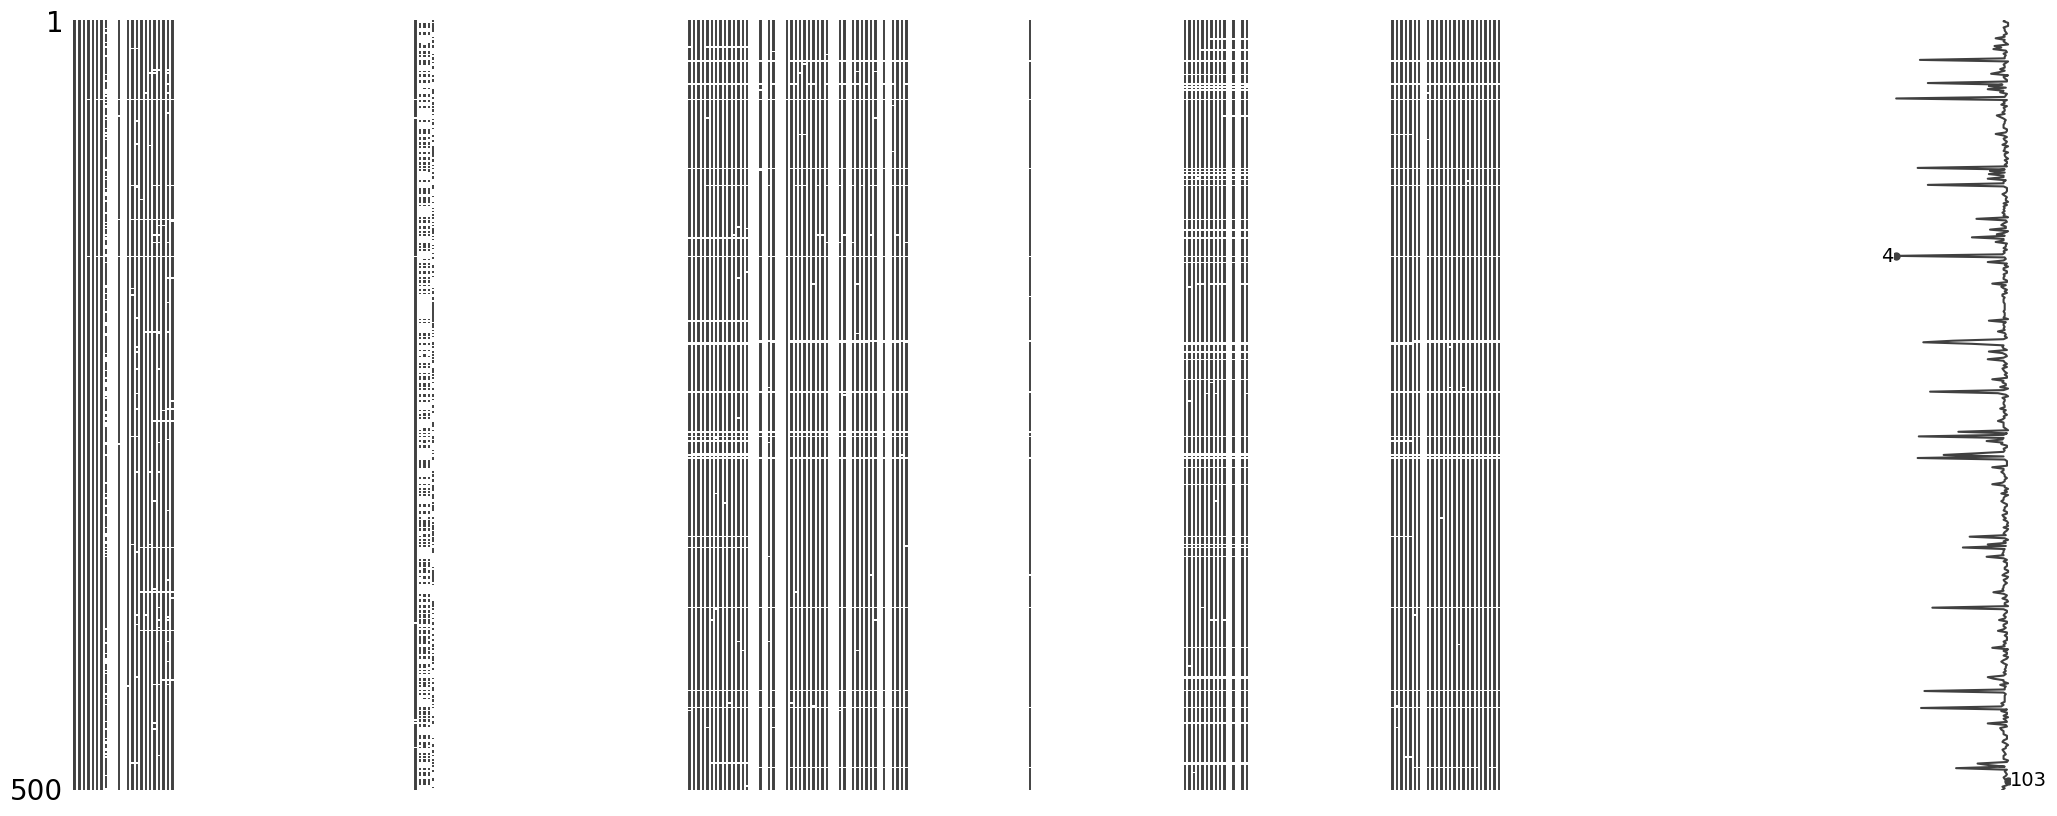

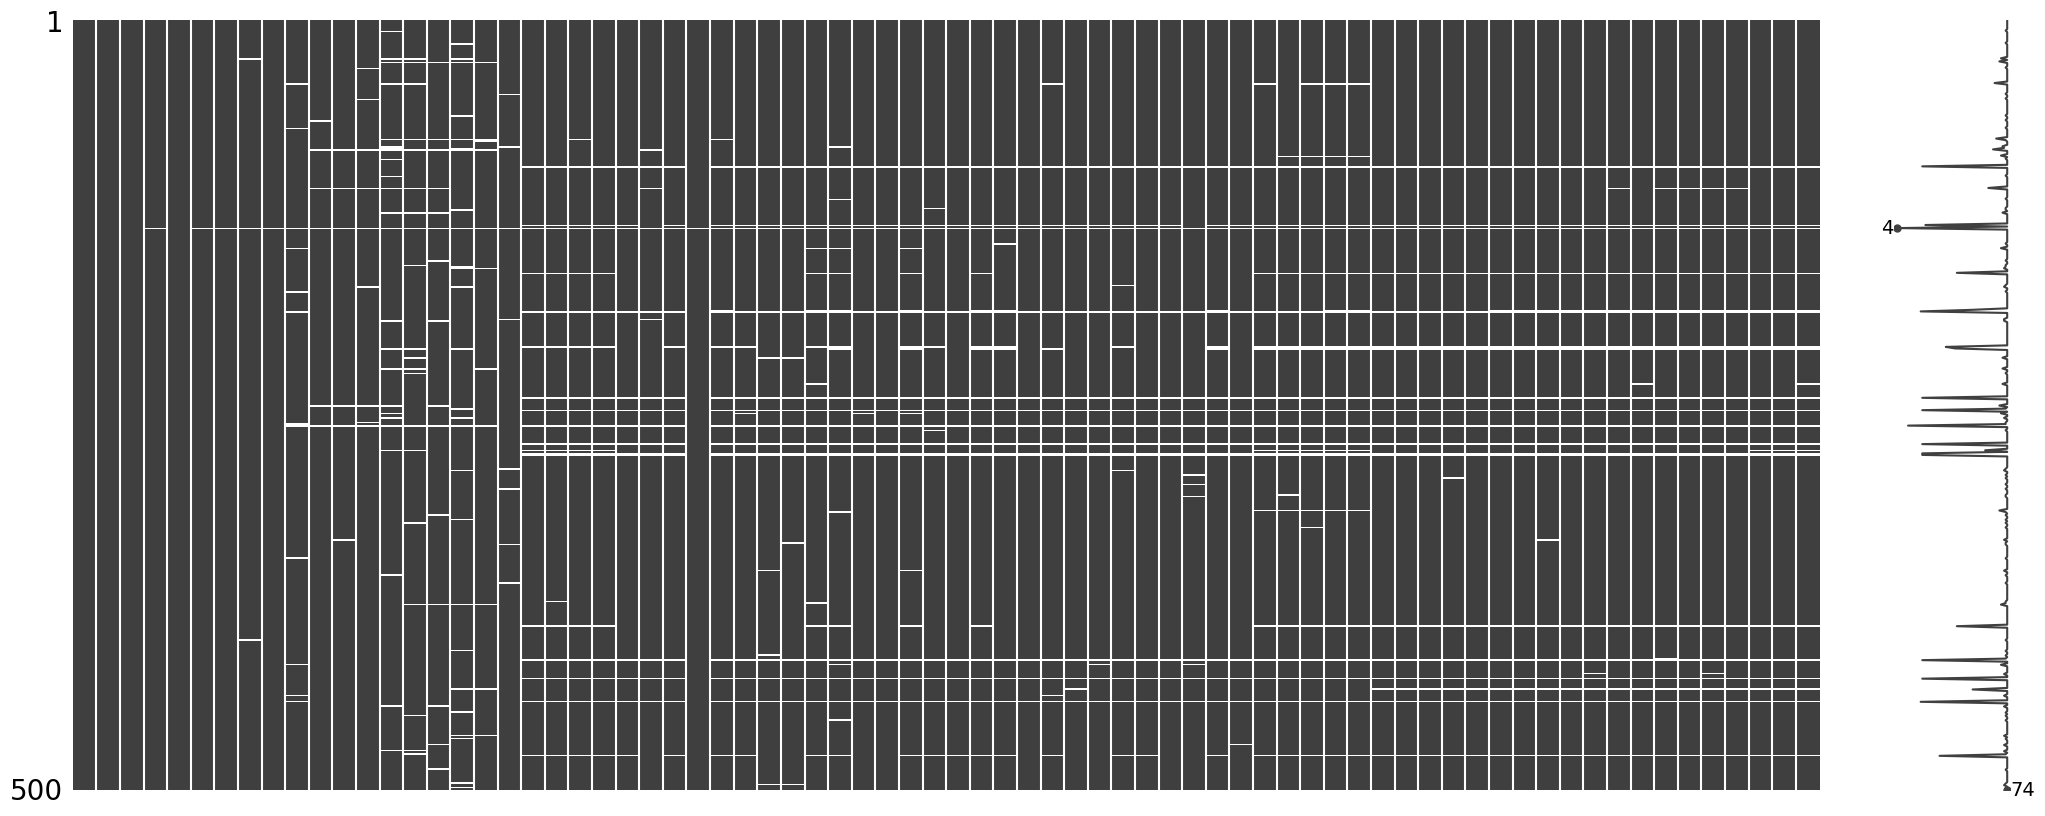

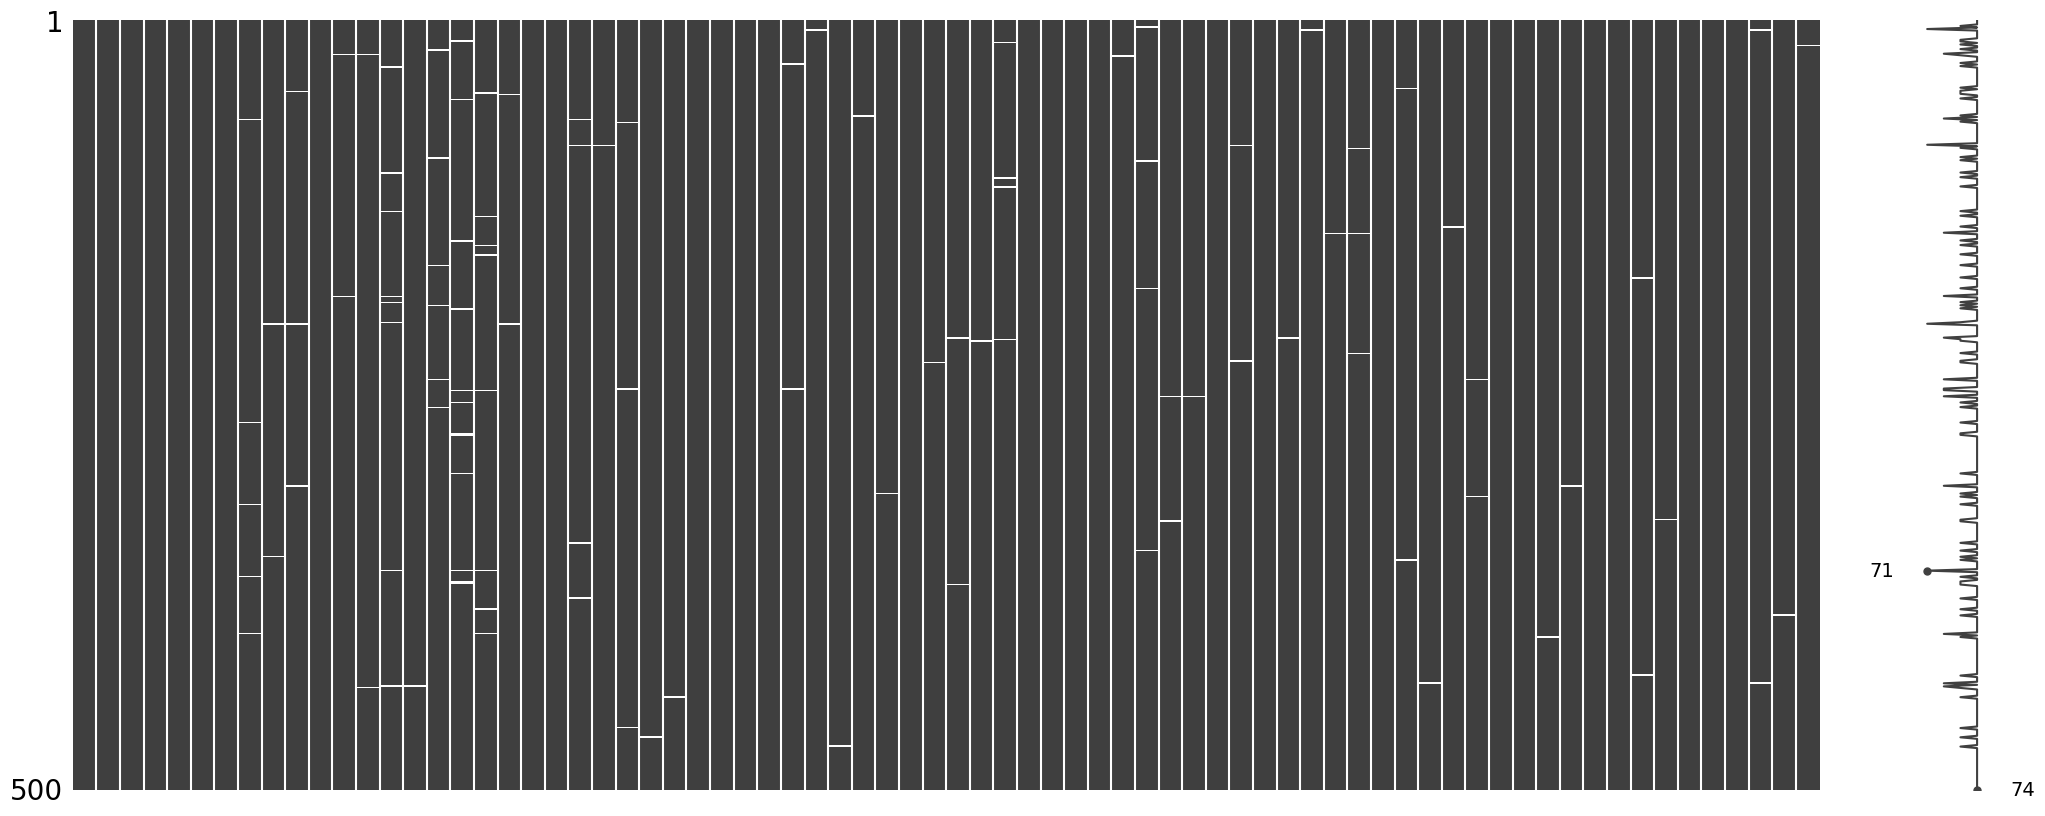

In [6]:
hs_df = clean_data(hs_df_raw)

As we can see here, we have a lot of missing data.
It's also worth noting that there seems to be some patterns to the missingness. 
For example it seems like people who are missing data in the first column of the middle chunk are more 
likely to have the proceeding columns also be missing. 

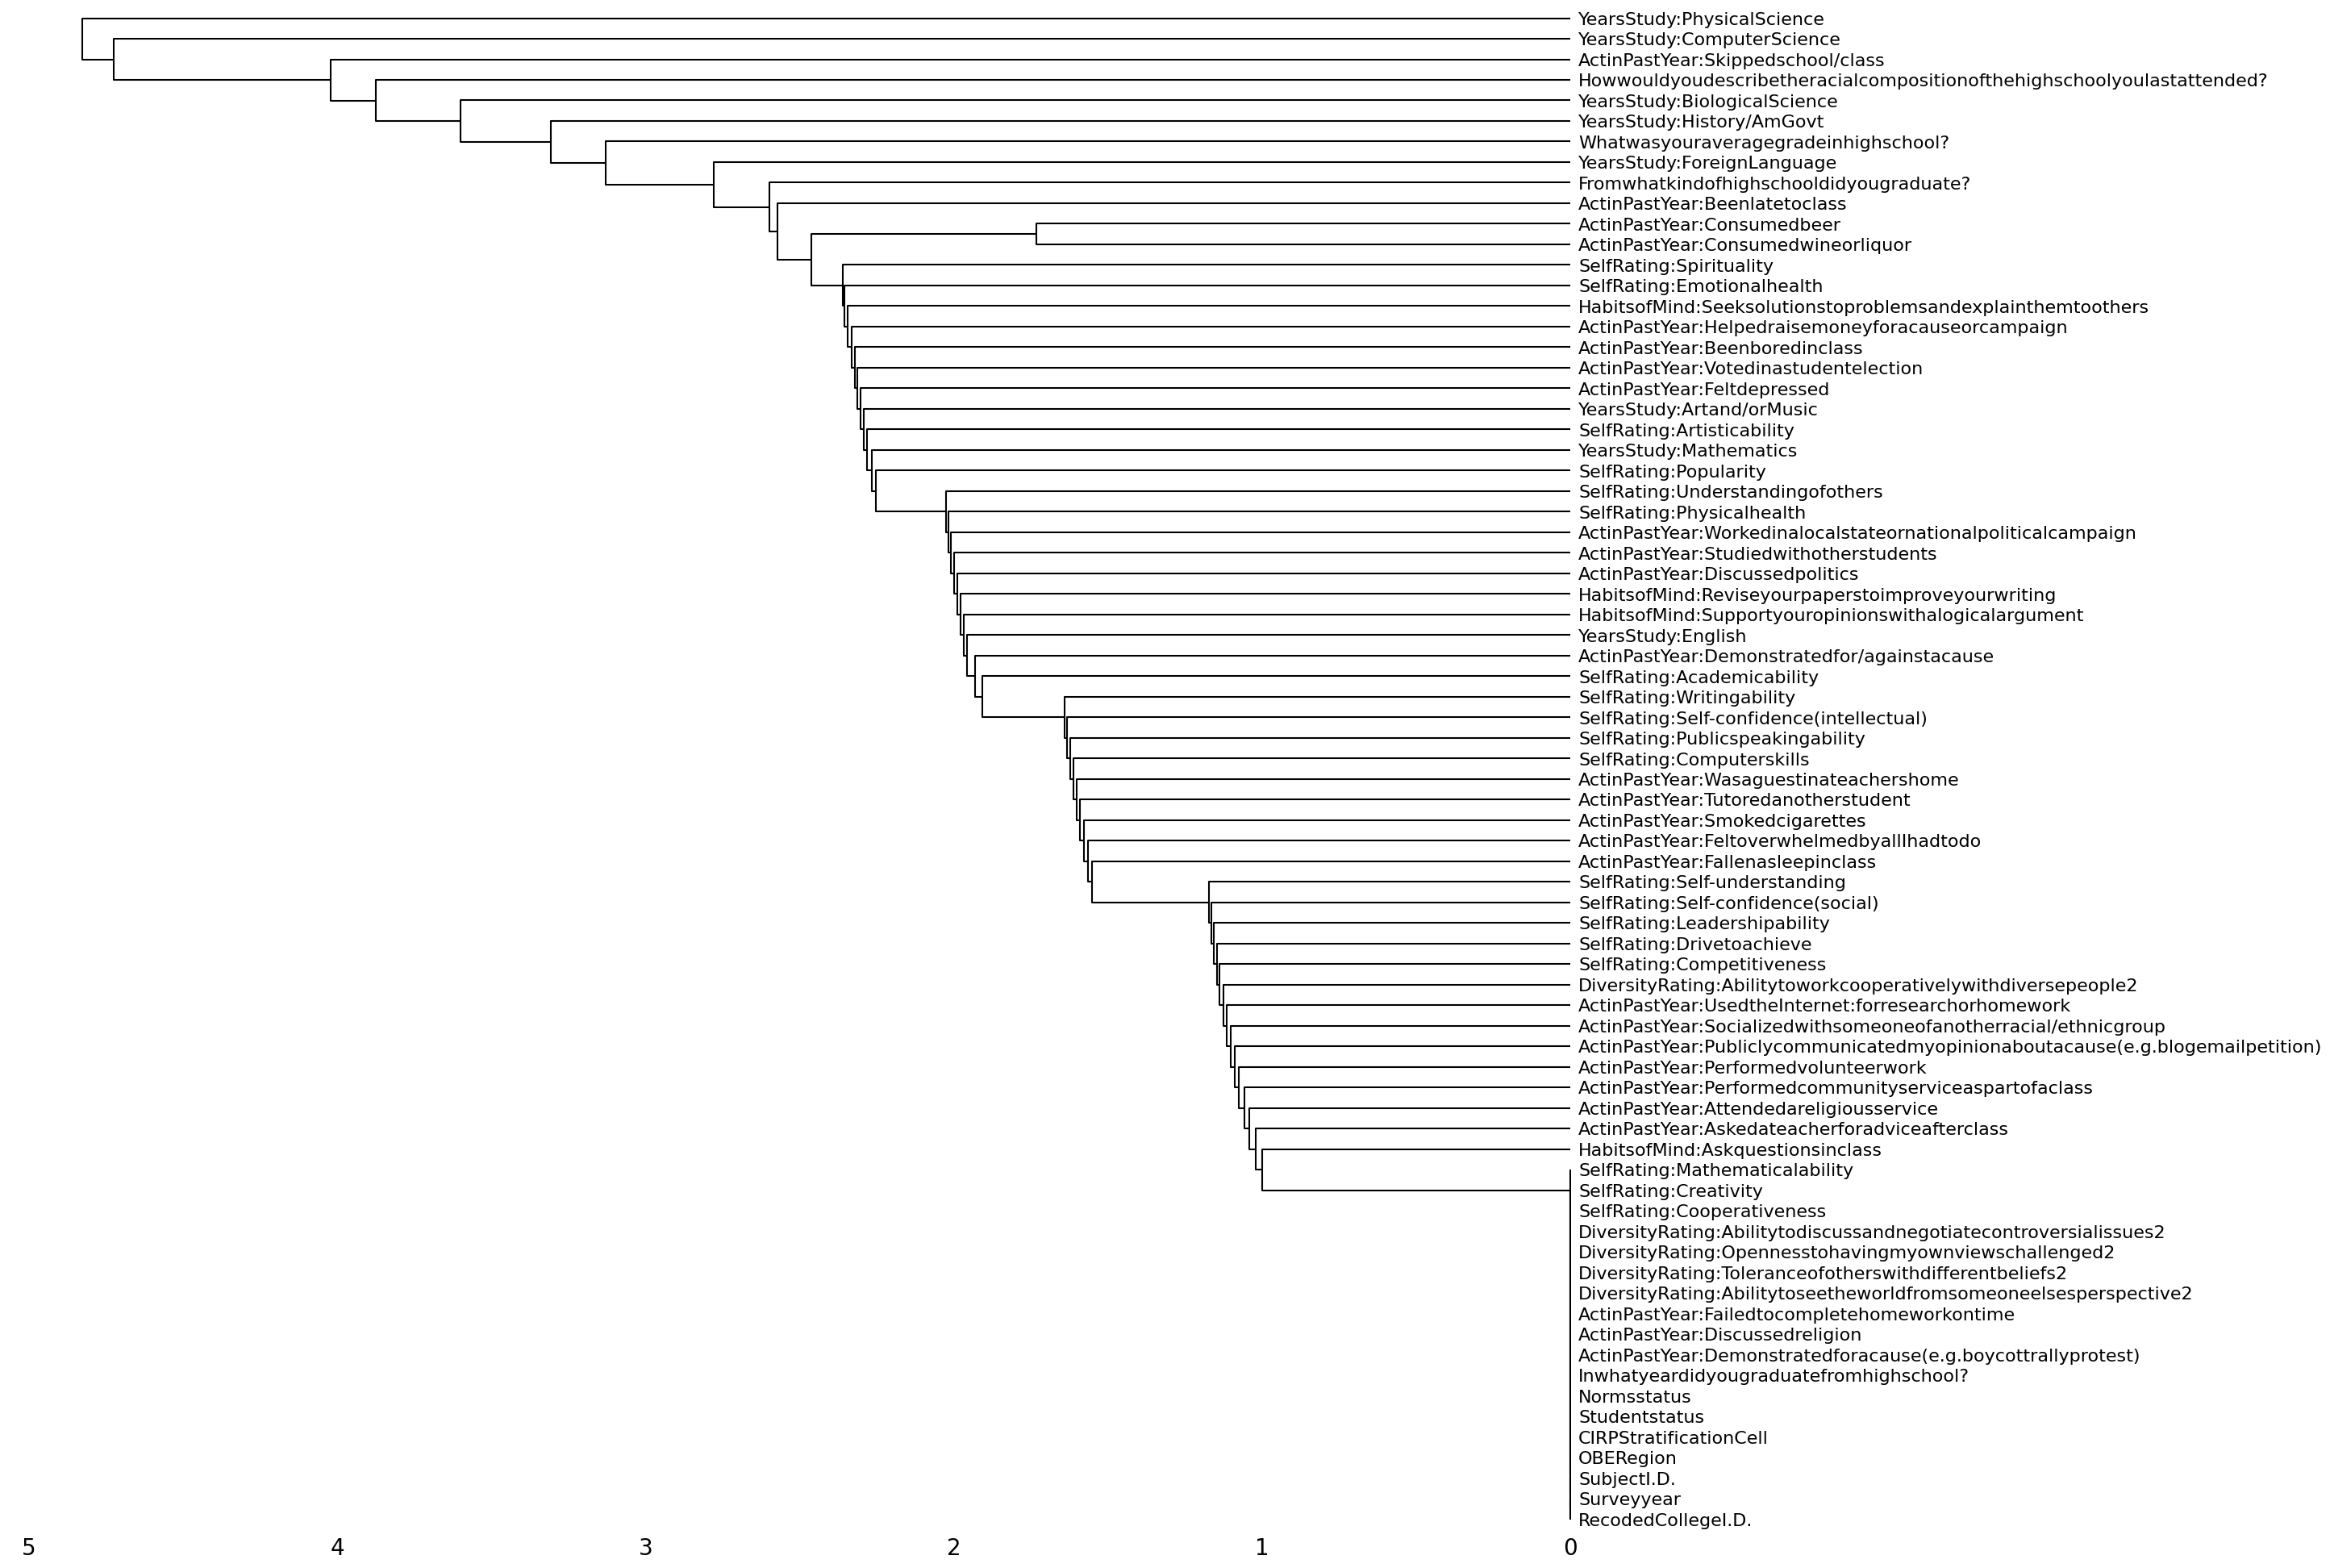

In [9]:
msno.dendrogram(hs_df.sample(1000))
plt.show();

"Leaves that are linked together fully predict one another's presence (i.e. one variable might always be empty when antoher is filled, or they might always both be filled or both empty, and so on)" [missingno documentation](https://github.com/ResidentMario/missingno).

It's interesting to note that While SATMath and SATVerbal are linked together, SATWriting is separated slightly.
Noteworthy since the writing component is not longer part of the SAT if I'm recalling correctly. 

In [ ]:
# Save all the columns to a txt file
with open("../stats/HIGH_SCHOOL_features.txt", "w") as f:
    for feature in hs_df.columns:
        f.writelines(f"{feature}\n")

## Demographics

In [23]:
db_path = "../data/00-external/DEMOGRAPHICS.db"

In [24]:
query_2010 = """
SELECT * FROM DEMOGRAPHICS
WHERE Surveyyear == 2010;
"""

dem_df_raw = run_query(db_path, query_2010)

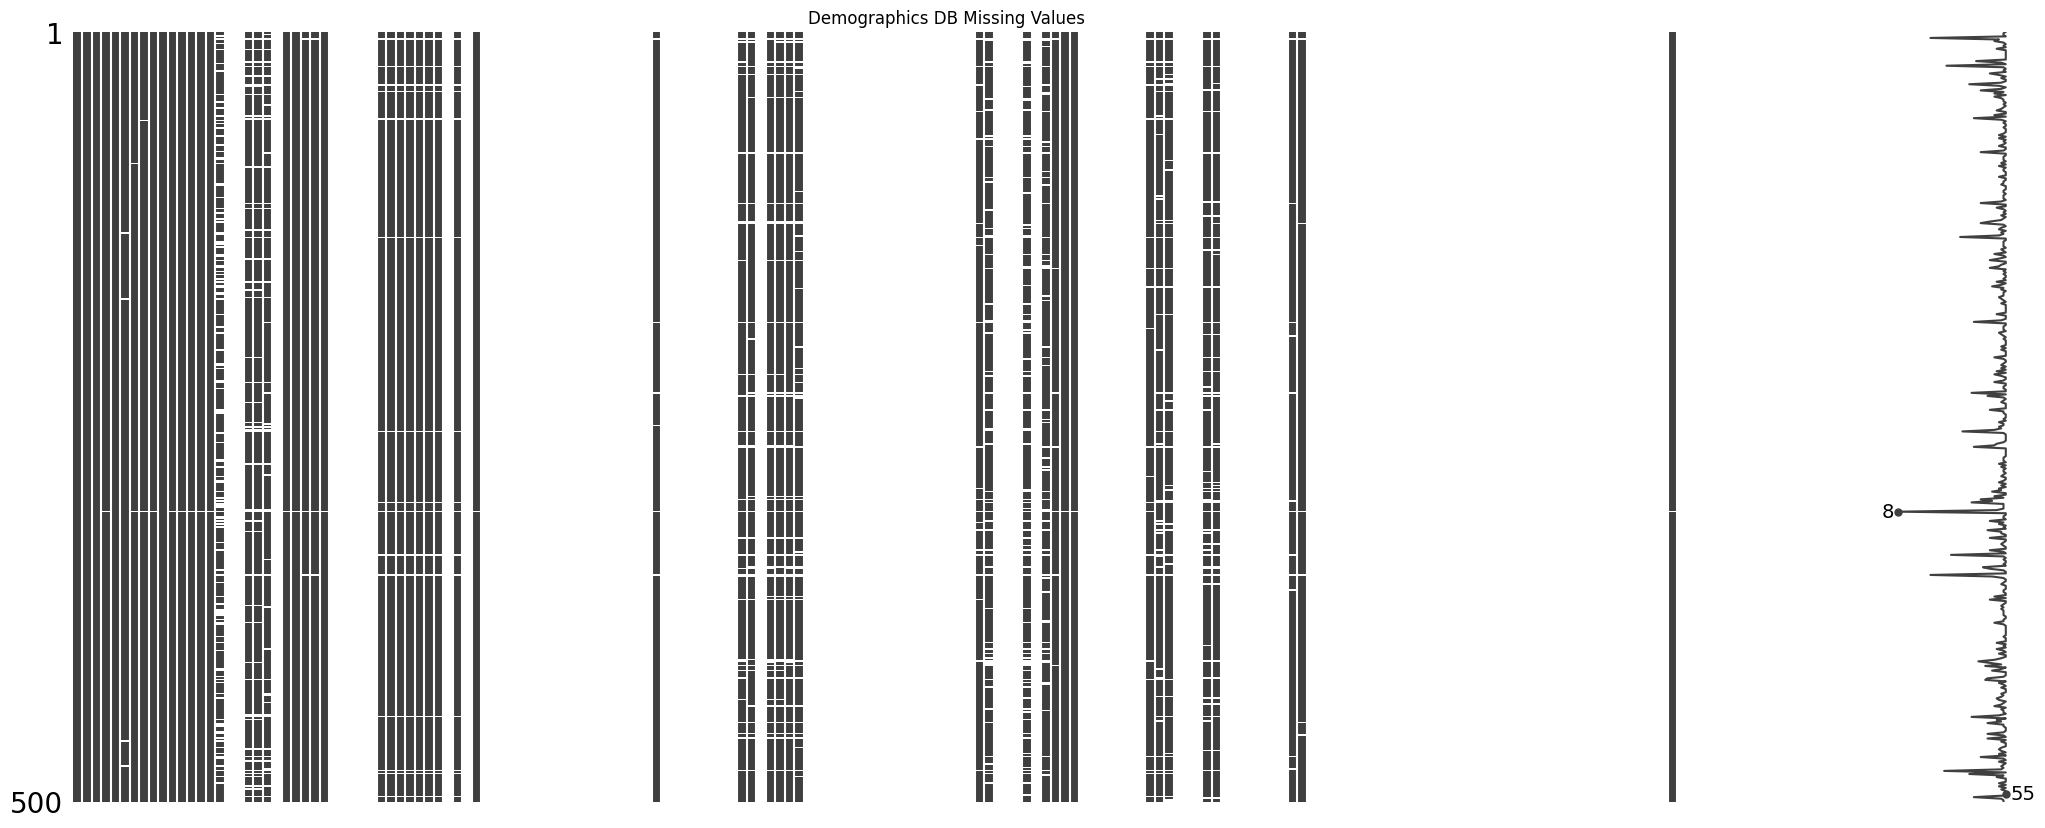

In [25]:
dem_df_raw_filled = dem_df_raw.fillna(value=np.nan)
msno.matrix(dem_df_raw_filled.sample(500))
plt.title("Demographics DB Missing Values")
plt.savefig("../stats/demo_db_msno.png")

In [27]:
demo_df_nmis = remove_missing_columns(dem_df_raw_filled)

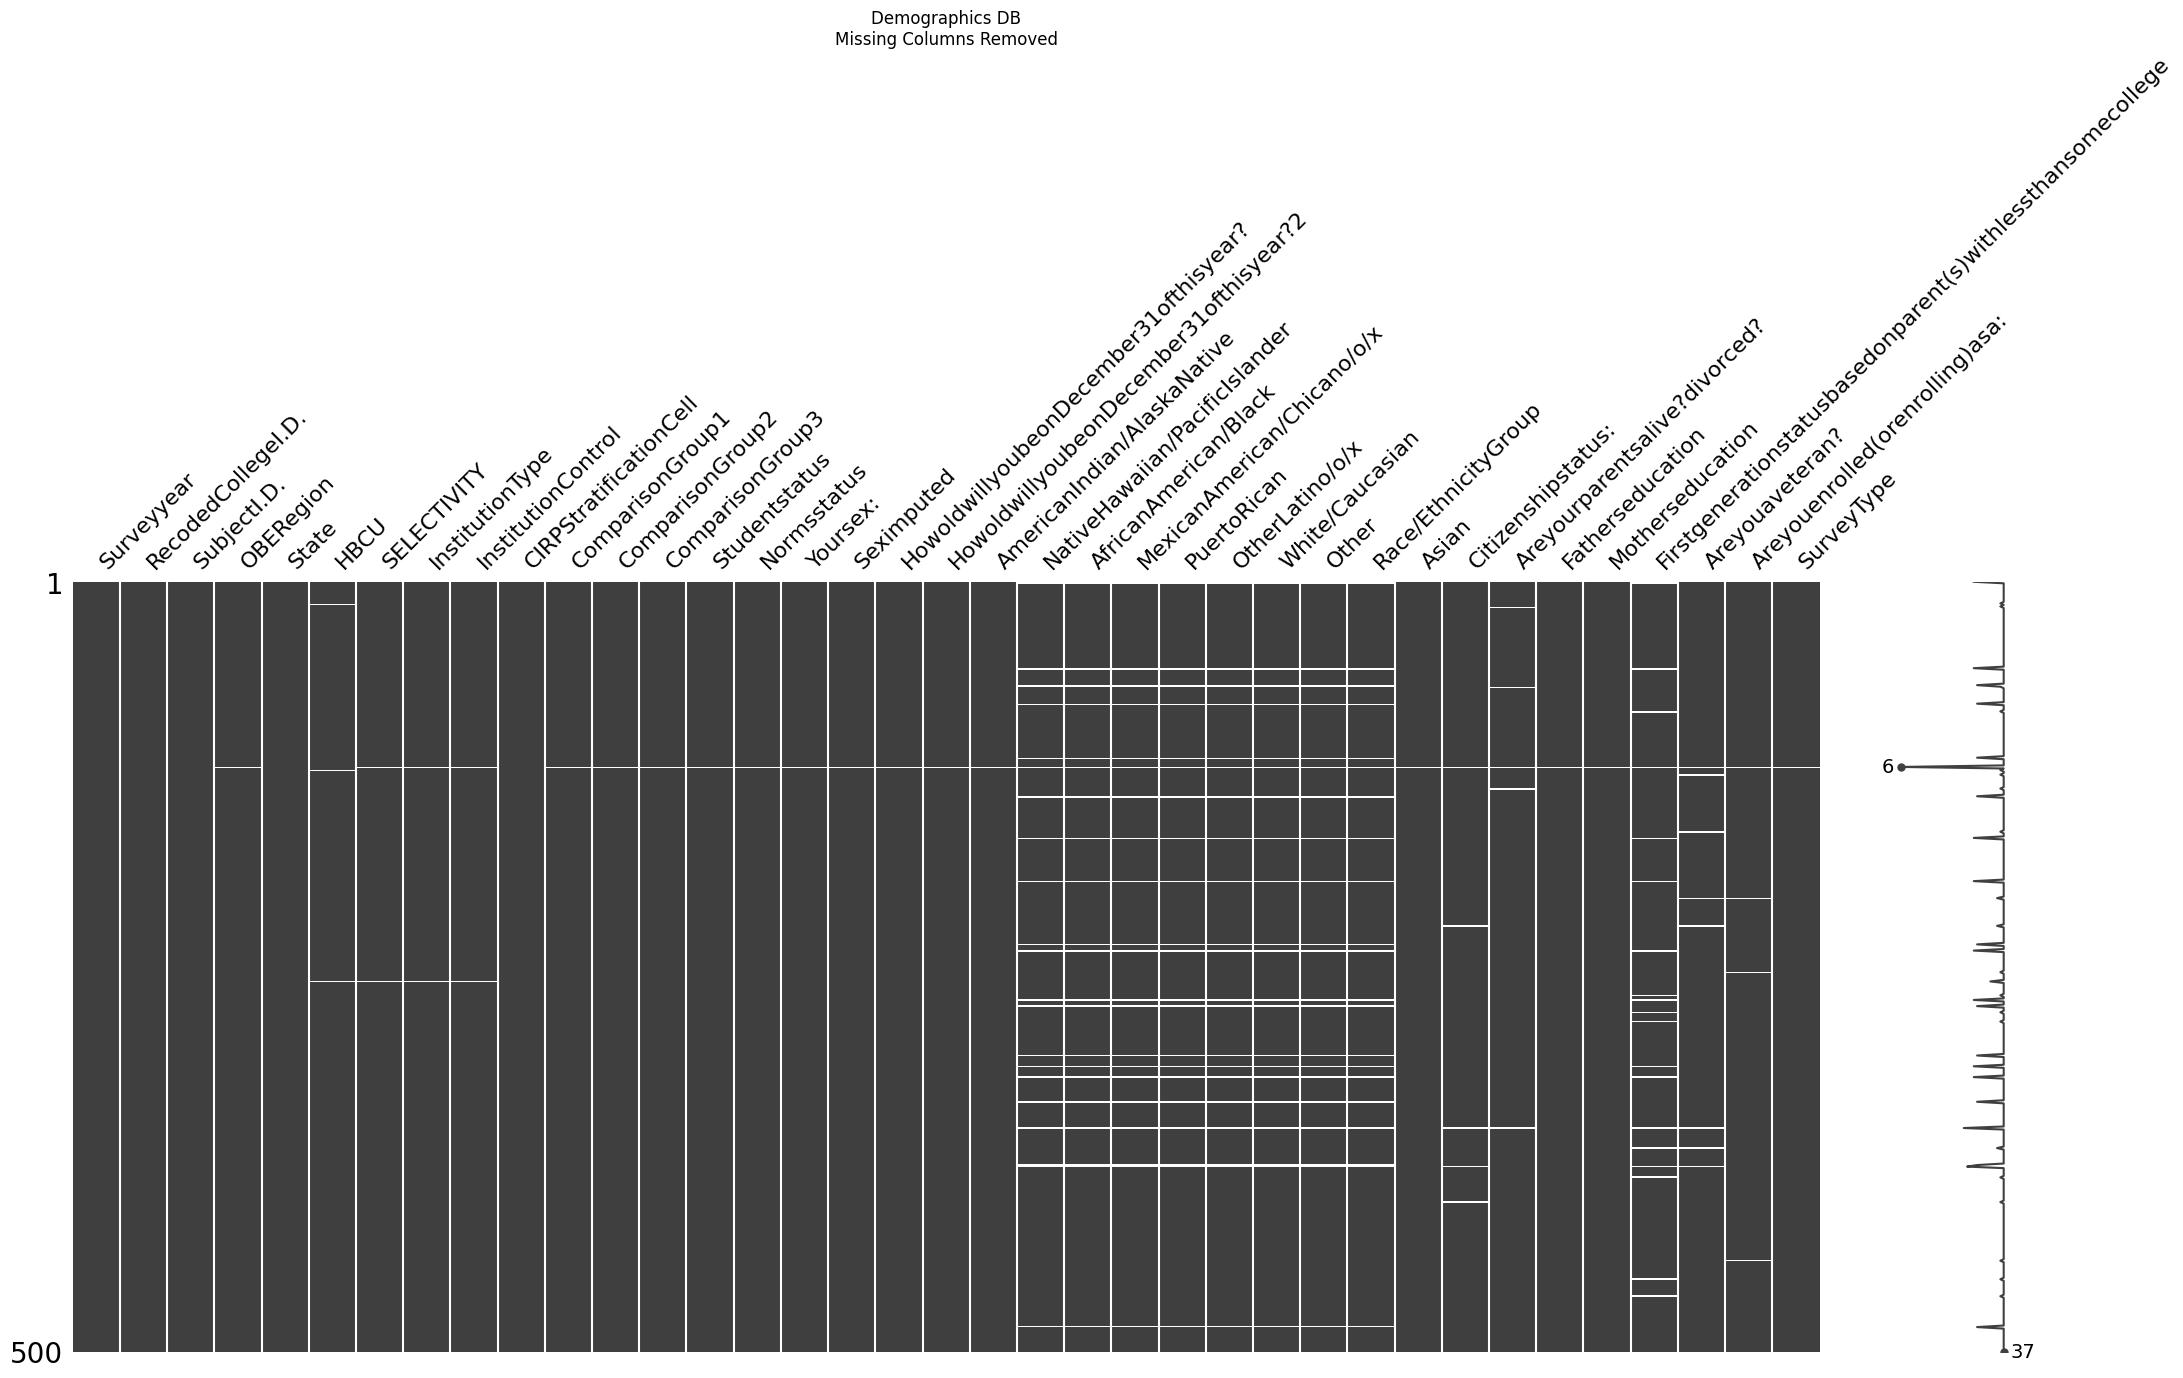

In [28]:
msno.matrix(demo_df_nmis.sample(500))
plt.title("Demographics DB\nMissing Columns Removed")
plt.savefig("../stats/demo_db_cols_removed_msno.png")

In [41]:
col = "Citizenshipstatus:"
print(f"NAs : {sum(dem_df_raw[col].isna())}")
print(f"Vals : {set(dem_df_raw[col].dropna())}")

NAs : 3212
Vals : {'Permanent resident', 'U.S. citizen', 'Neither/None of the above'}


In [31]:
# list(demo_df_nmis.columns)
list(dem_df_raw.columns)

['Surveyyear',
 'RecodedCollegeI.D.',
 'SubjectI.D.',
 'OBERegion',
 'State',
 'HBCU',
 'SELECTIVITY',
 'InstitutionType',
 'InstitutionControl',
 'CIRPStratificationCell',
 'ComparisonGroup1',
 'ComparisonGroup2',
 'ComparisonGroup3',
 'Studentstatus',
 'Normsstatus',
 'Studentweight',
 'Partialwebsurveyresponse',
 'DoyougiveHERIpermissiontoincludeyouridnumbershouldyourcollegerequestthedataforadditionalresearchanalyses?',
 'DOBMonth',
 'DOBYear',
 'Studentshomezip',
 'Whatisyourcurrentgenderidentity?',
 'Yoursex:',
 'Seximputed',
 'HowoldwillyoubeonDecember31ofthisyear?',
 'HowoldwillyoubeonDecember31ofthisyear?2',
 'AmericanIndian/AlaskaNative',
 'EastAsian(e.g.ChineseJapaneseKoreanTaiwanese)',
 'Filipino',
 'SoutheastAsian(e.g.CambodianVietnameseHmong)',
 'SouthAsian(e.g.IndianPakistaniNepaleseSriLankan)',
 'OtherAsian',
 'NativeHawaiian/PacificIslander',
 'AfricanAmerican/Black',
 'MexicanAmerican/Chicano/o/x',
 'PuertoRican',
 'OtherLatino/o/x',
 'White/Caucasian',
 'Other',
 'Sou

Raw Data
Columns Filtered
Rows filtered


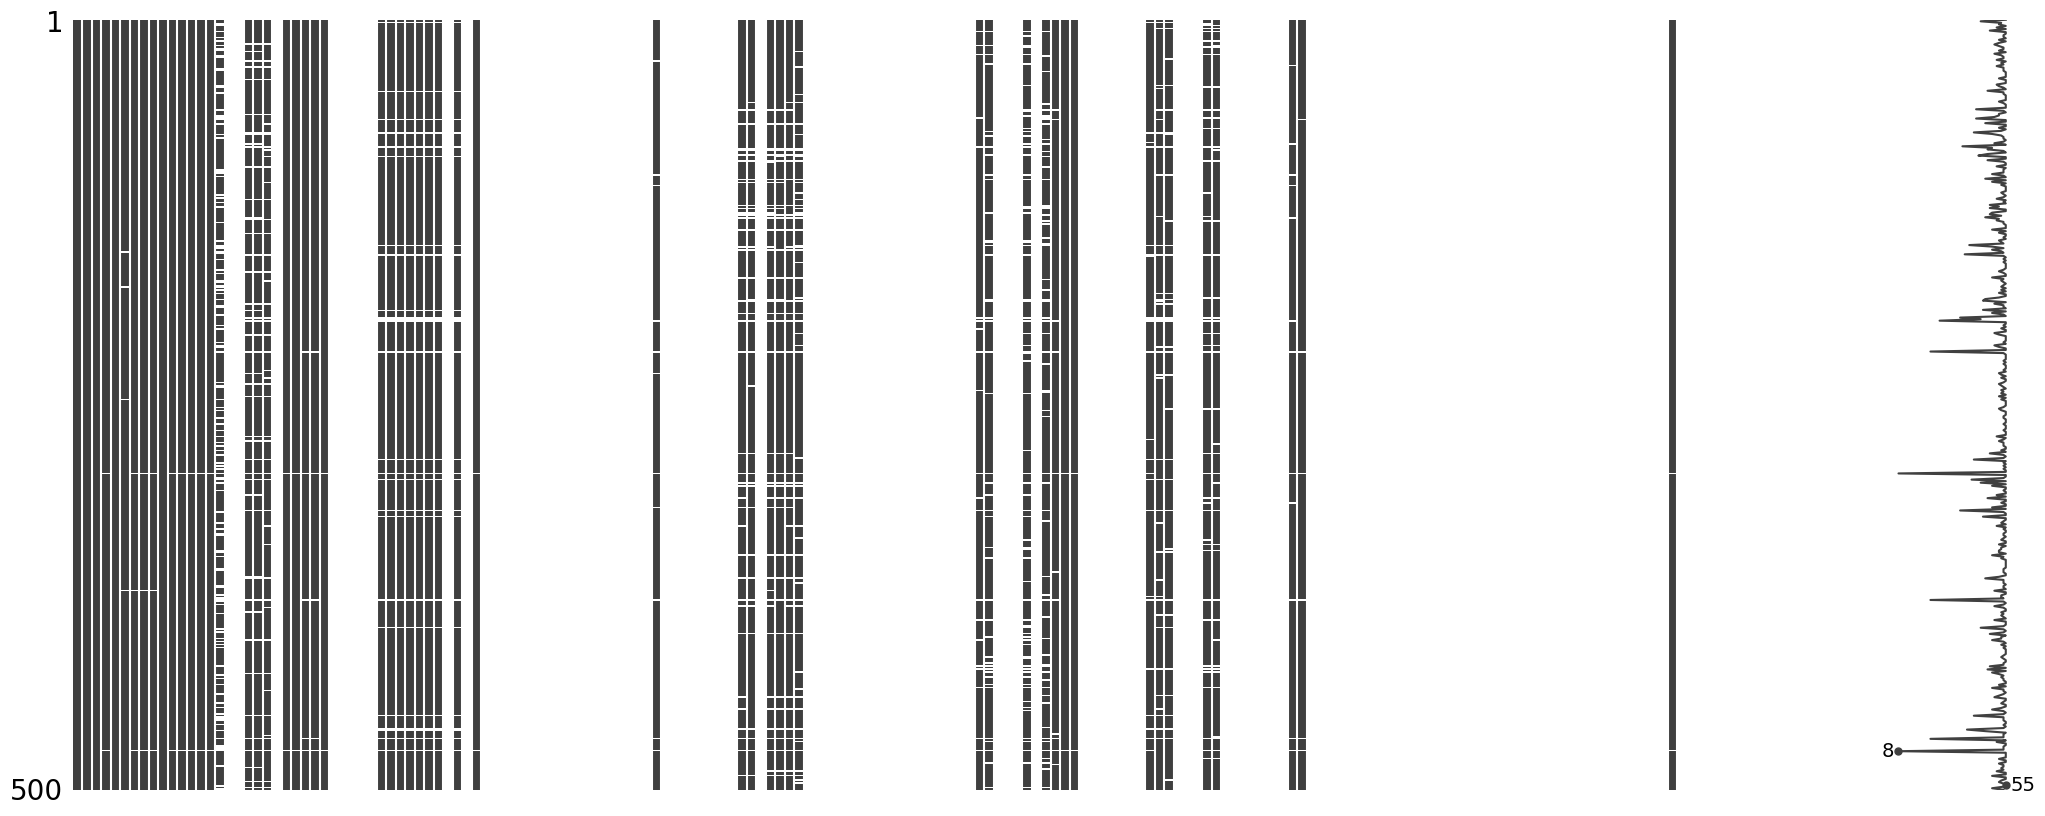

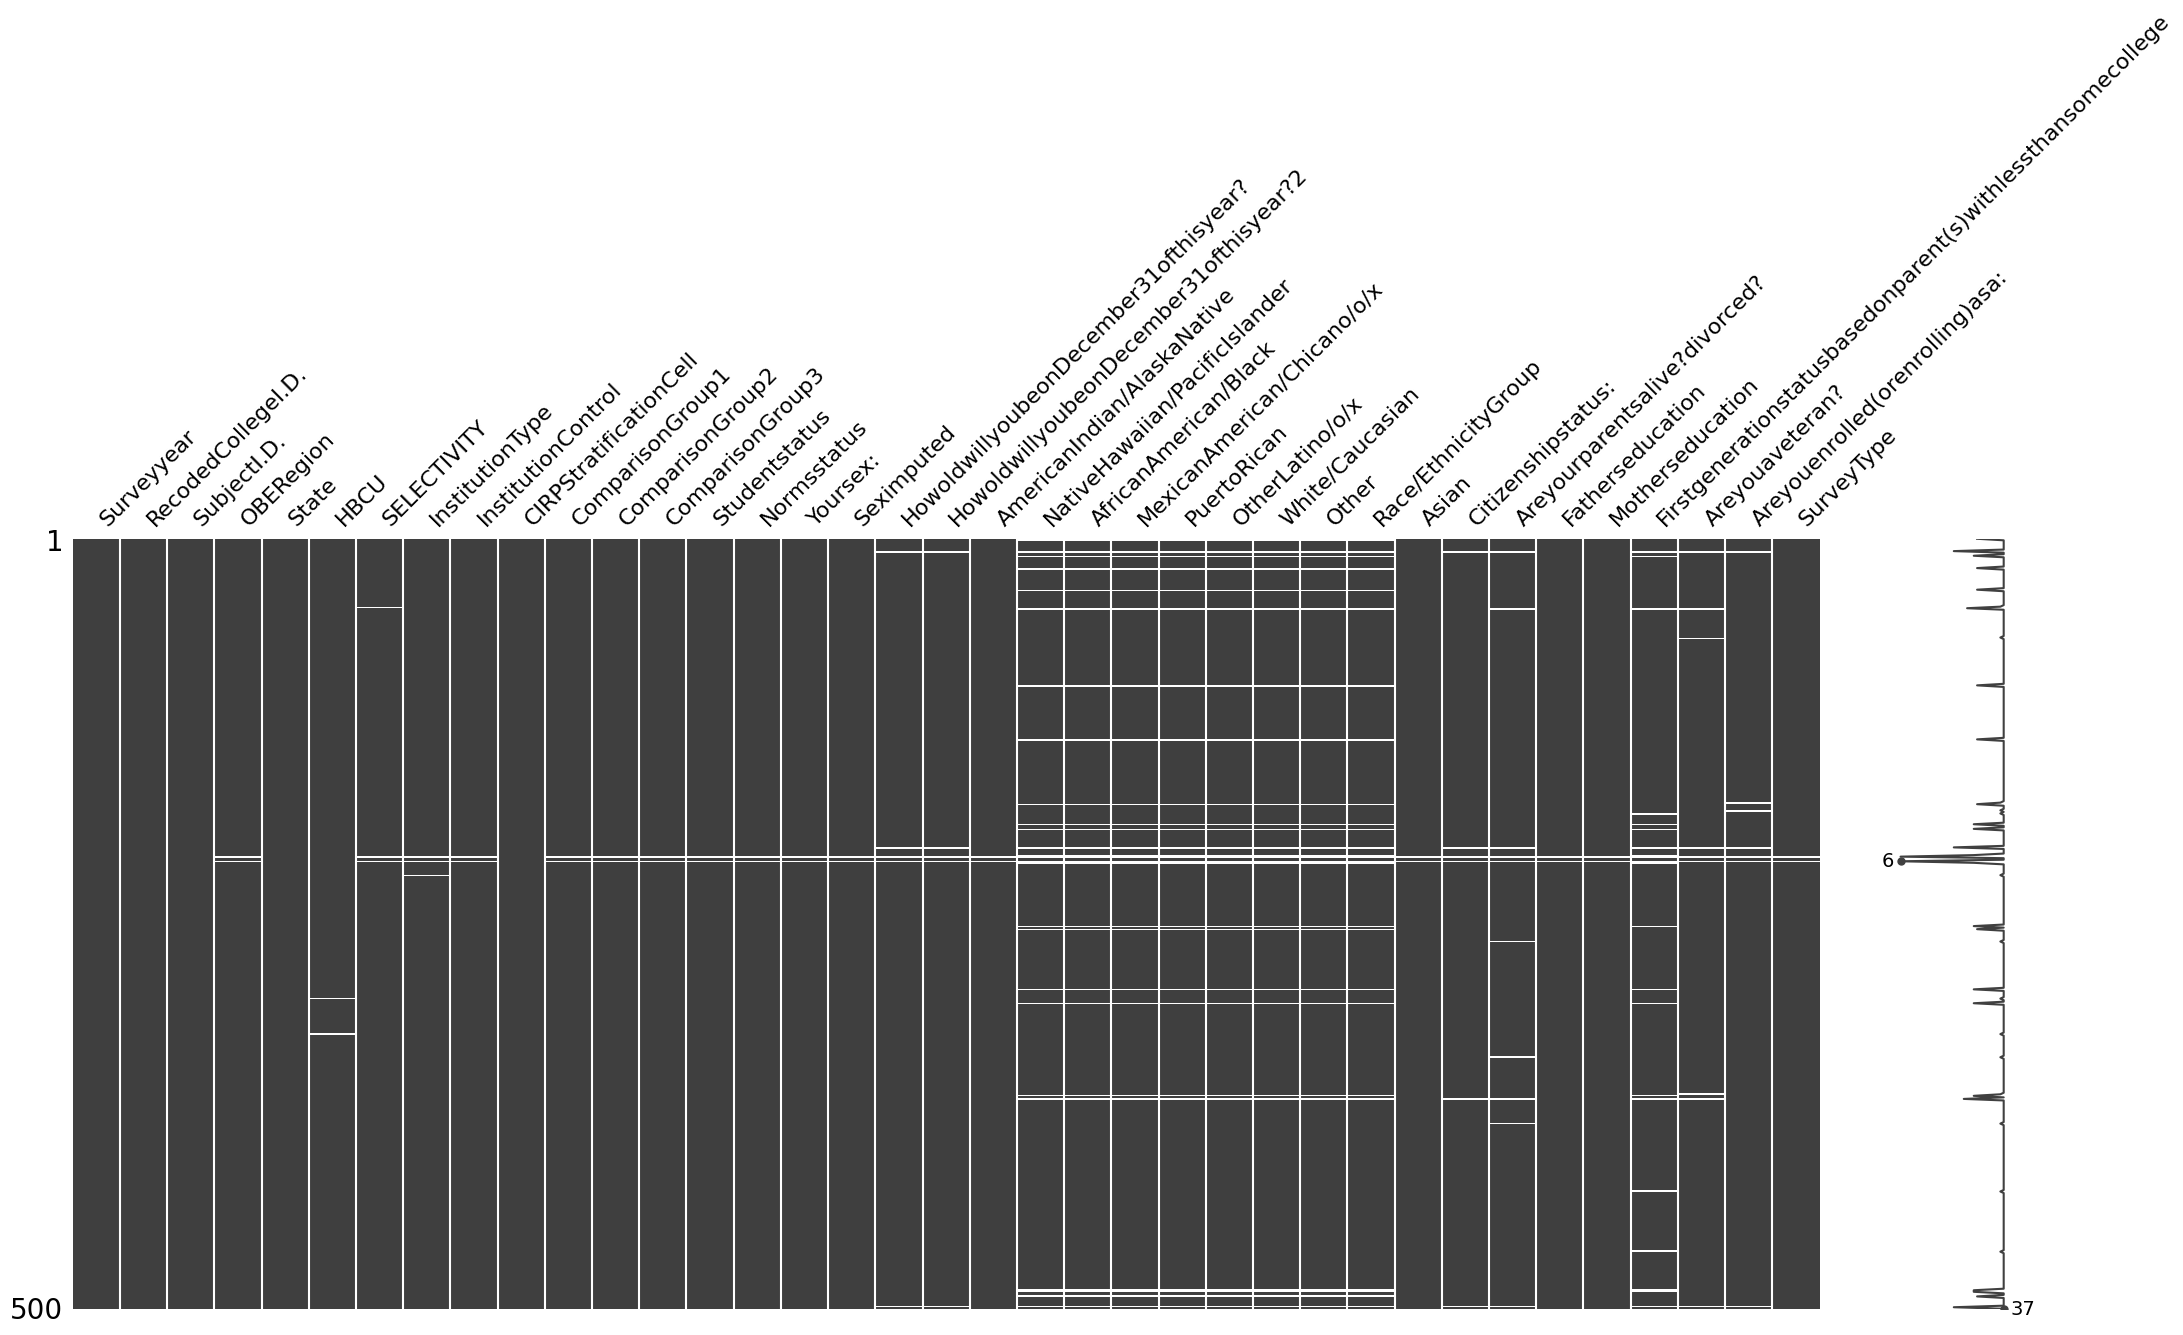

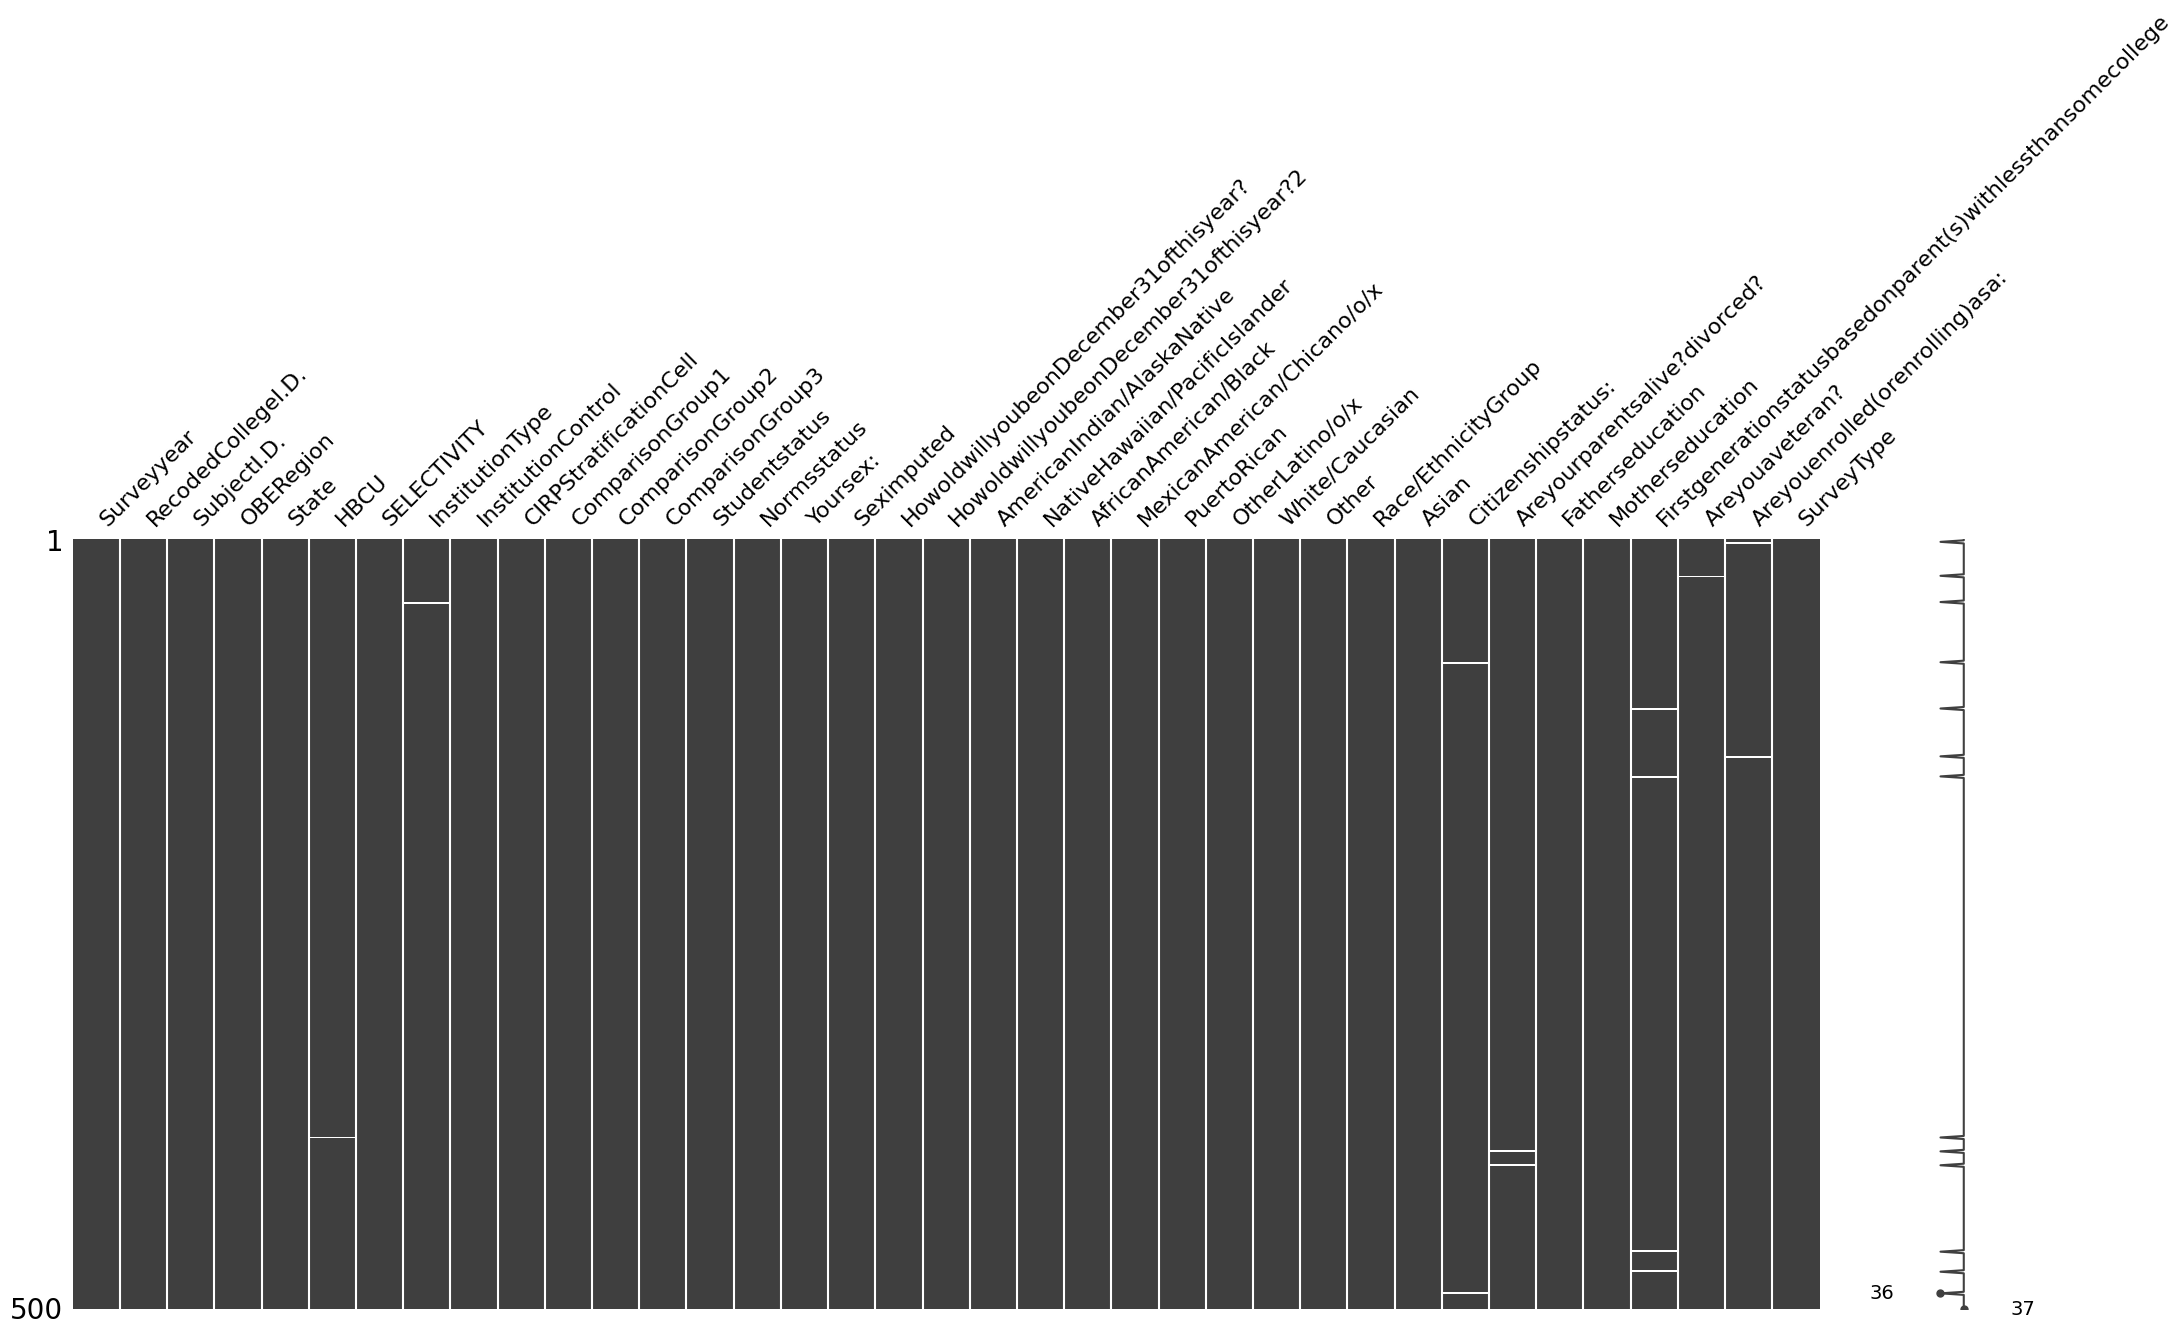

In [12]:
dem_df = clean_data(dem_df_raw)

In [ ]:
print(dem_df_raw.shape)
print(dem_df.shape)

(262433, 184)
(247628, 37)


We're loosing a lot of data to missing values!

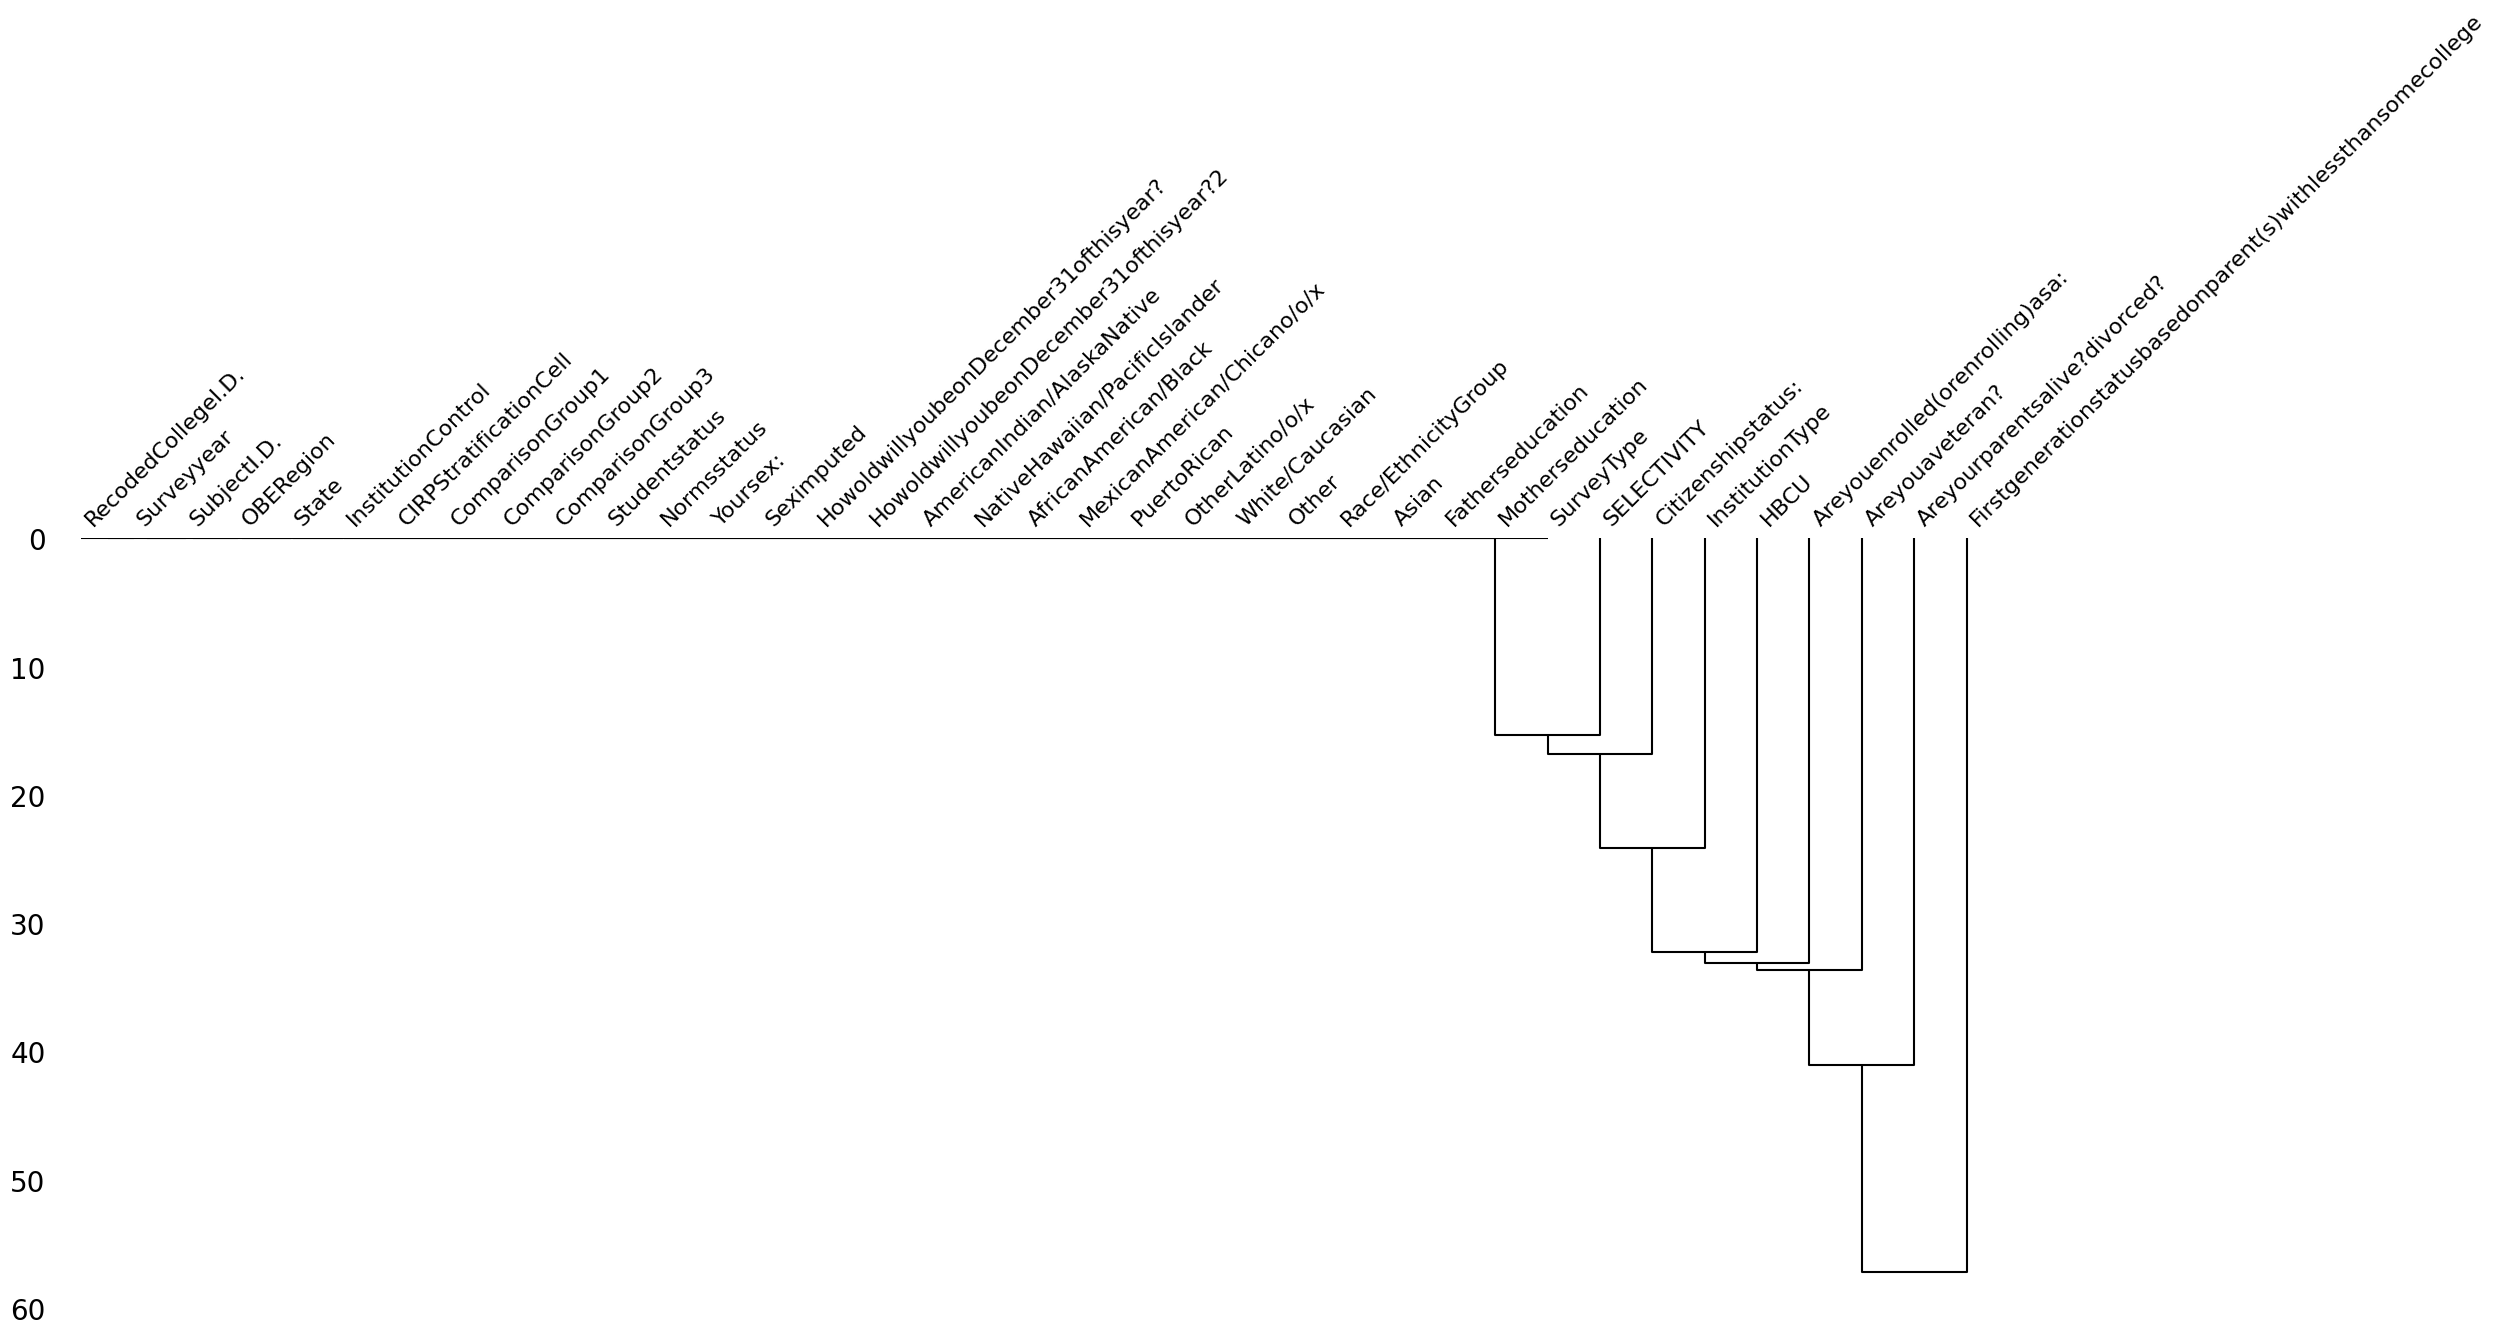

In [ ]:
msno.dendrogram(dem_df)
plt.show();

In [ ]:
# Save all the columns to a txt file
with open("../stats/DEMOGRAPHICS_features.txt", "w") as f:
    for feature in dem_df.columns:
        f.writelines(f"{feature}\n")

## TFS Choice

In [42]:
db_path = "../data/00-external/TFS_CHOICE_2008_2010.db"

In [14]:
with sqlite3.connect("../data/00-external/TFS_CHOICE_2008_2010.db") as conn:
    cursor = conn.cursor()
    cursor.execute("""
        SELECT name FROM sqlite_schema
        WHERE type='table'
        ORDER BY name;
    """)
    print(cursor.fetchall())

[('CHOICE',)]


In [43]:
query_2010 = """
SELECT * FROM CHOICE
WHERE Year == 2010;
"""

tfs_df_raw = run_query(db_path, query_2010)

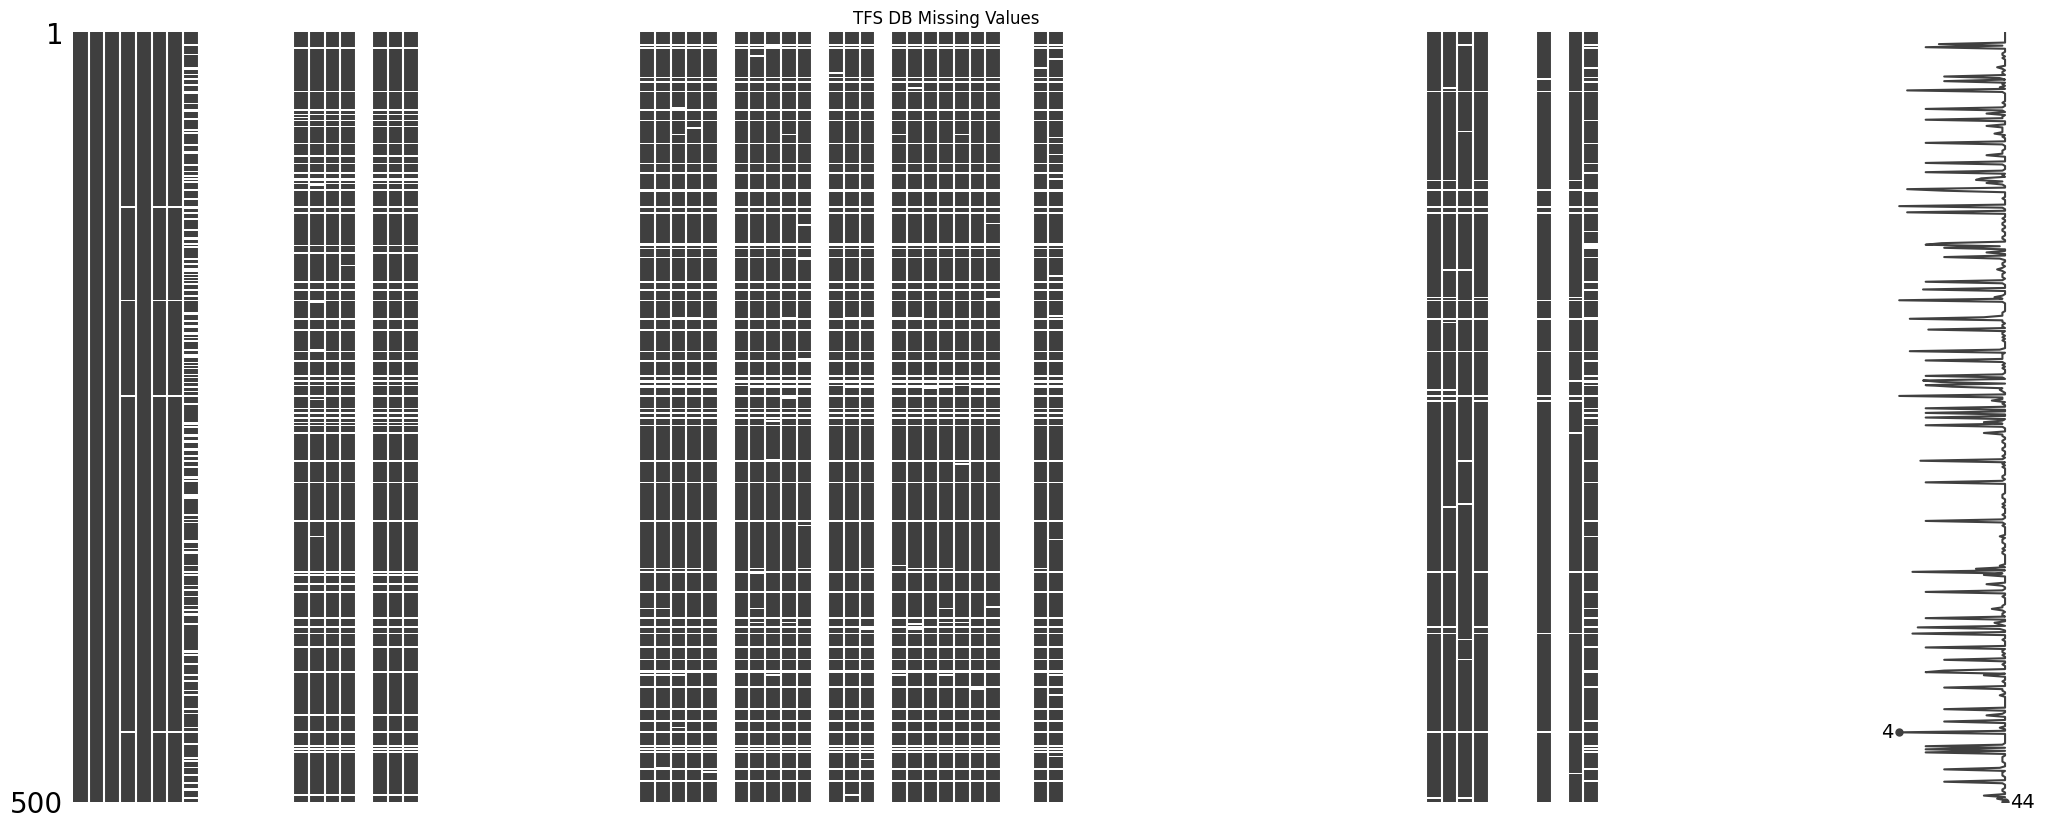

In [44]:
tfs_filled = tfs_df_raw.fillna(value=np.nan)
msno.matrix(tfs_filled.sample(500))
plt.title("TFS DB Missing Values")
plt.savefig("../stats/tfs_db_msno.png")

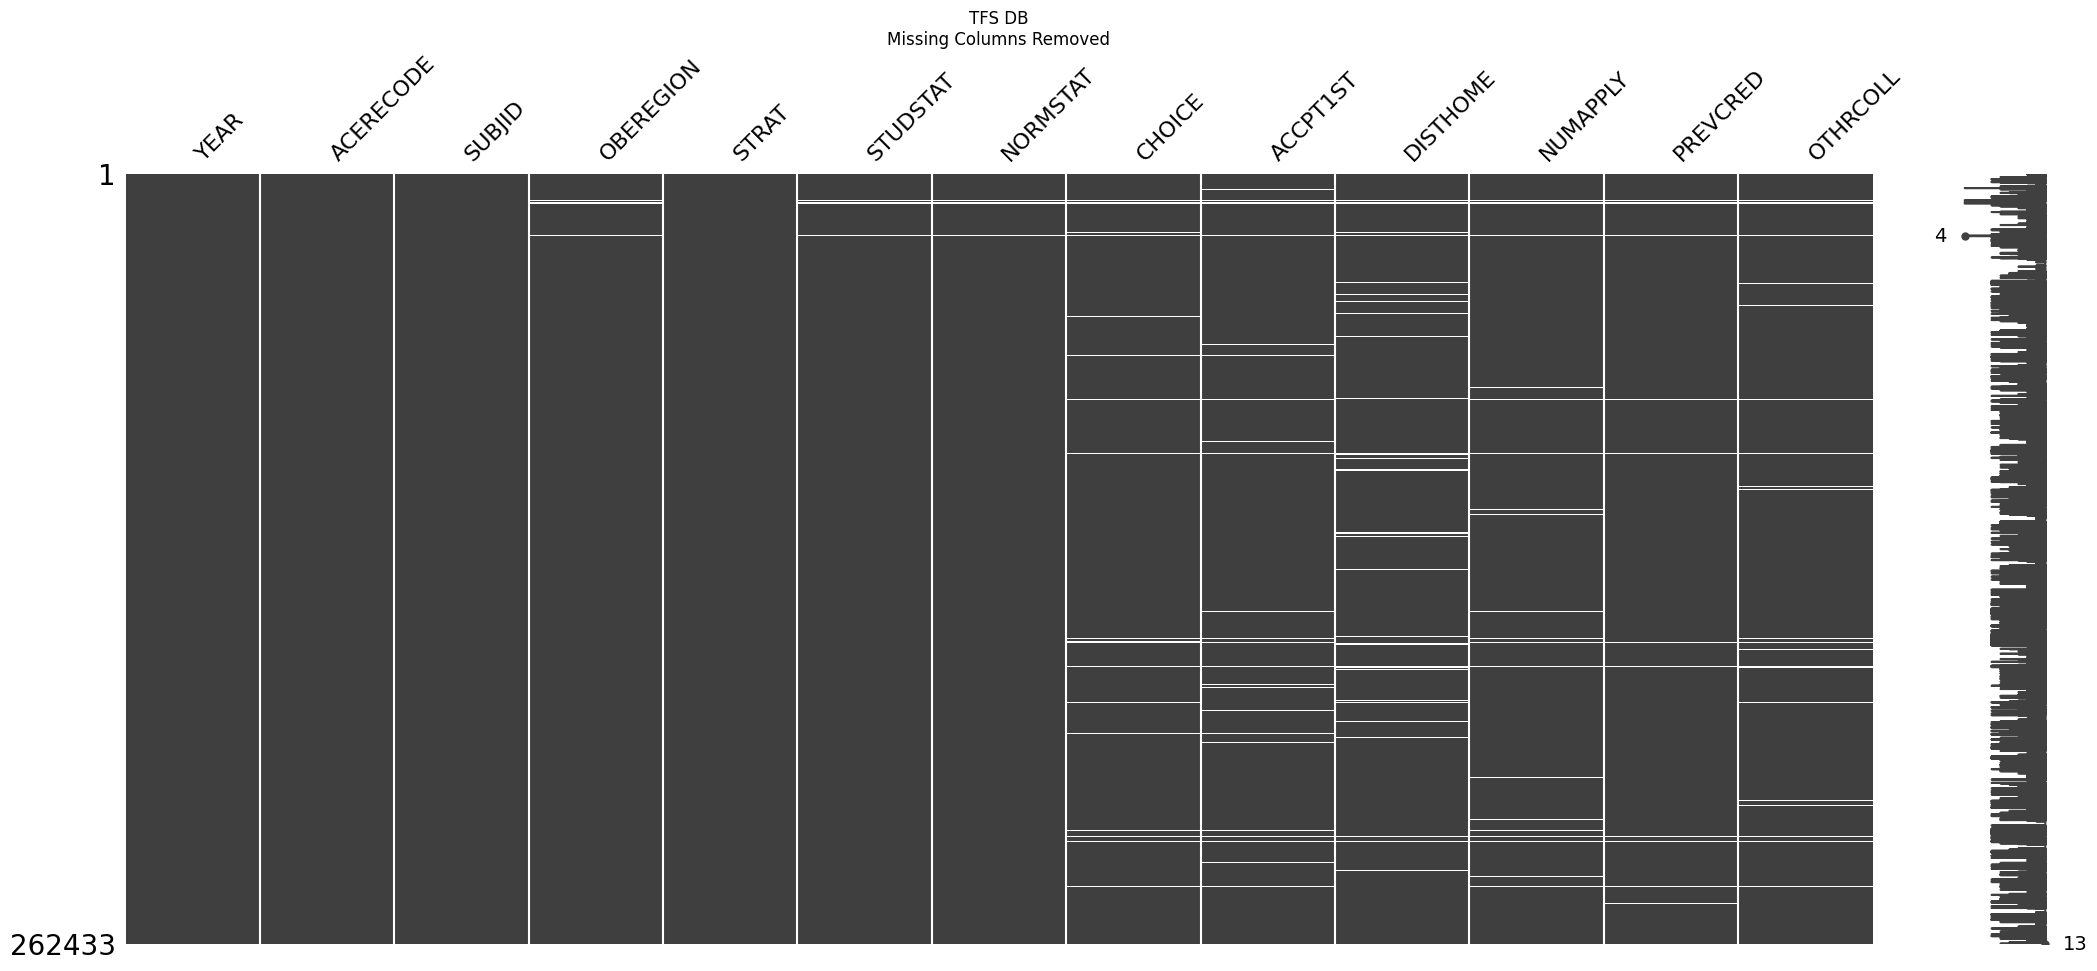

In [45]:
tfs_nmis = remove_missing_columns(tfs_filled)
msno.matrix(tfs_nmis)
plt.title("TFS DB\nMissing Columns Removed")
plt.savefig("../stats/tfs_db_cols_removed.png")

In [46]:
list(tfs_filled.columns)

['YEAR',
 'ACERECODE',
 'SUBJID',
 'OBEREGION',
 'STRAT',
 'STUDSTAT',
 'NORMSTAT',
 'STUDWGT',
 'PARTIAL',
 'INCOMPLETE',
 'REASON01',
 'REASON02',
 'REASON03',
 'REASON04',
 'REASON05',
 'REASON06',
 'REASON08',
 'REASON07',
 'REASON09',
 'REASON10',
 'REASON11',
 'REASON12',
 'REASON13',
 'REASON14',
 'REASON01_T',
 'REASON02_T',
 'REASON03_T',
 'REASON04_T',
 'REASON05_T',
 'REASON06_T',
 'REASON07_T',
 'REASON01_N',
 'REASON02_N',
 'REASON03_N',
 'CHOOSE01',
 'CHOOSE02',
 'CHOOSE03',
 'CHOOSE04',
 'CHOOSE05',
 'CHOOSE06',
 'CHOOSE07',
 'CHOOSE08',
 'CHOOSE09',
 'CHOOSE10',
 'CHOOSE11',
 'CHOOSE12',
 'CHOOSE13',
 'CHOOSE14',
 'CHOOSE15',
 'CHOOSE16',
 'CHOOSE17',
 'CHOOSE18',
 'CHOOSE19',
 'CHOOSE20',
 'CHOOSE21',
 'CHOOSE22',
 'CHOOSE23',
 'CHOOSE24',
 'CHOOSE25',
 'CHOOSE26',
 'CHOOSE27',
 'CHOOSE28',
 'CHOOSE29',
 'CHOOSE30',
 'CHOOSE31',
 'CHOOSE32',
 'CHOOSE33',
 'CHOOSE34',
 'CHOOSE35',
 'CHOOSE01_T',
 'CHOOSE02_T',
 'CHOOSE03_T',
 'CHOOSE04_T',
 'CHOOSE05_T',
 'CHOOSE06_T',


Raw Data
Columns Filtered
Rows filtered


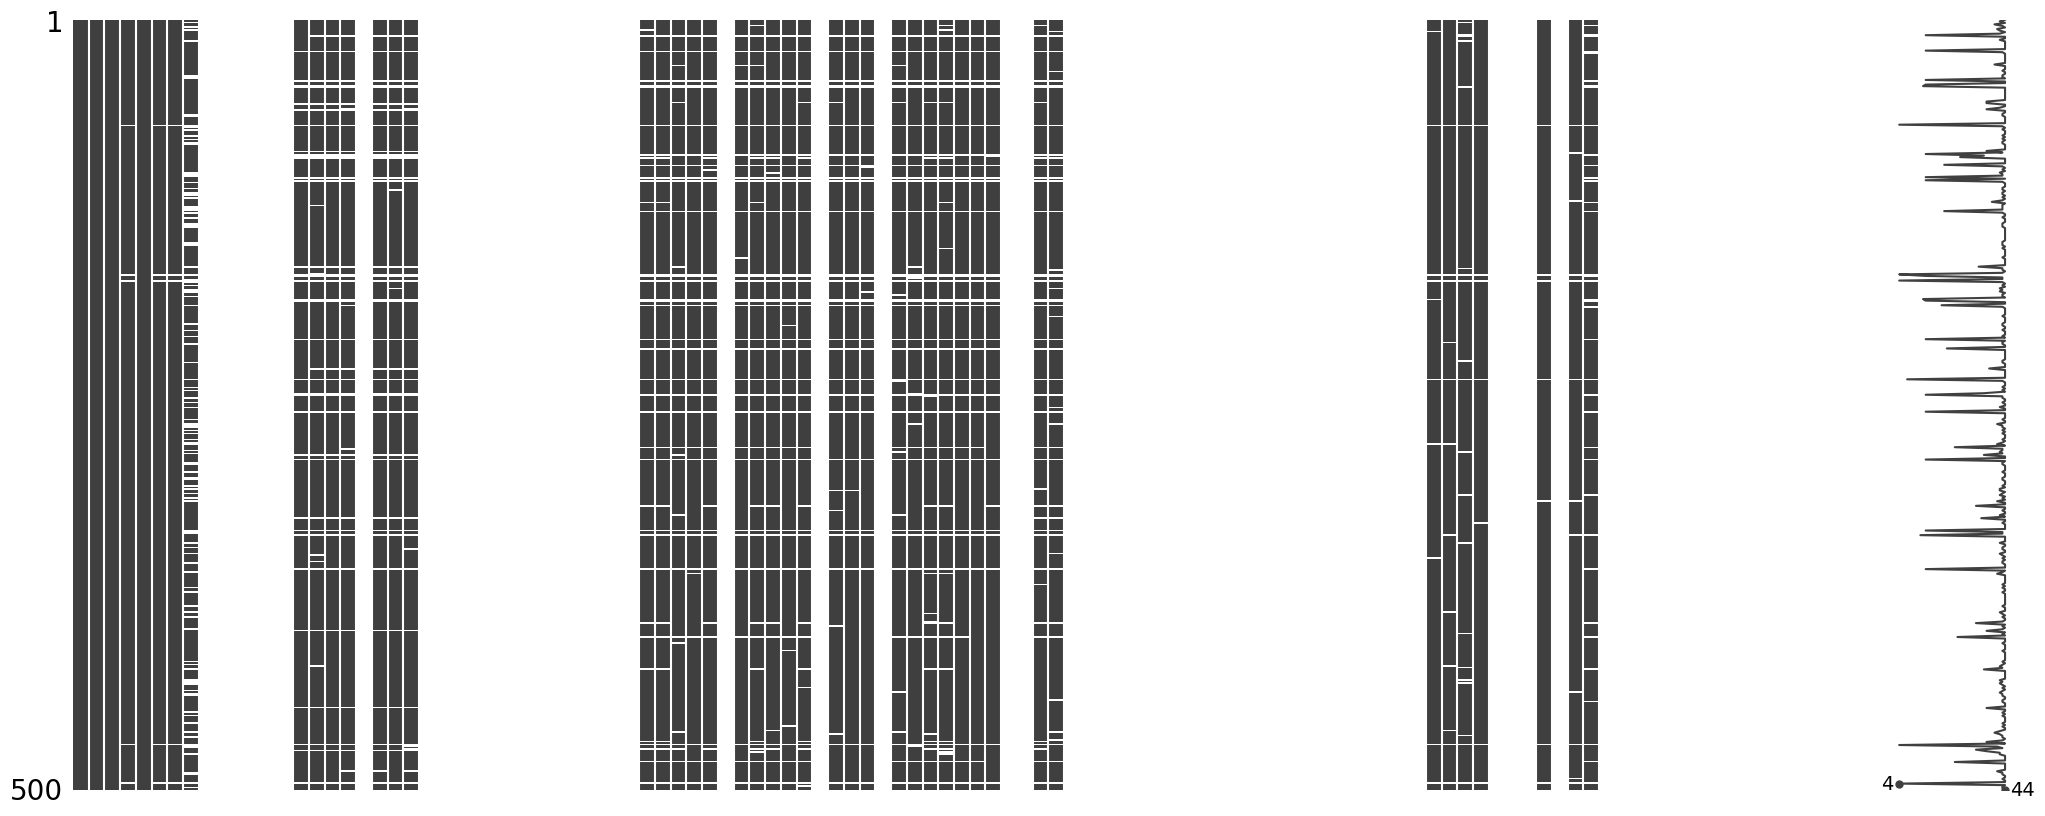

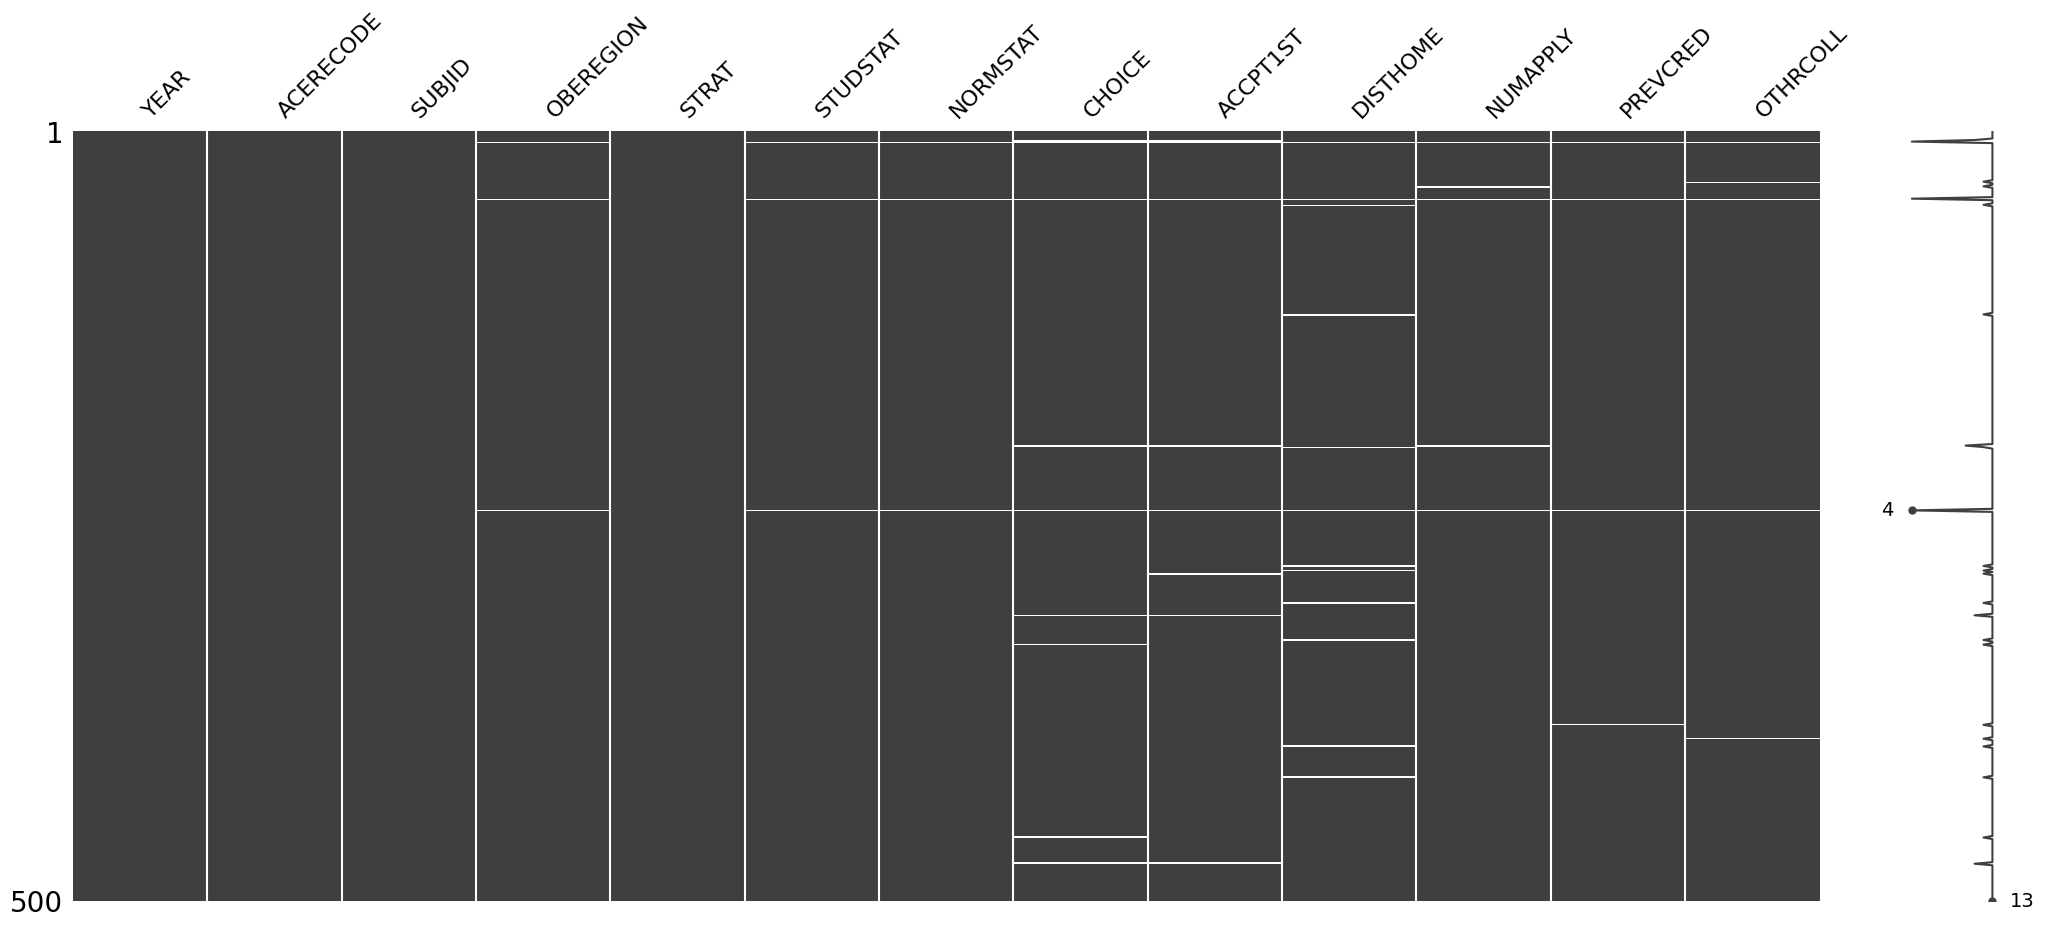

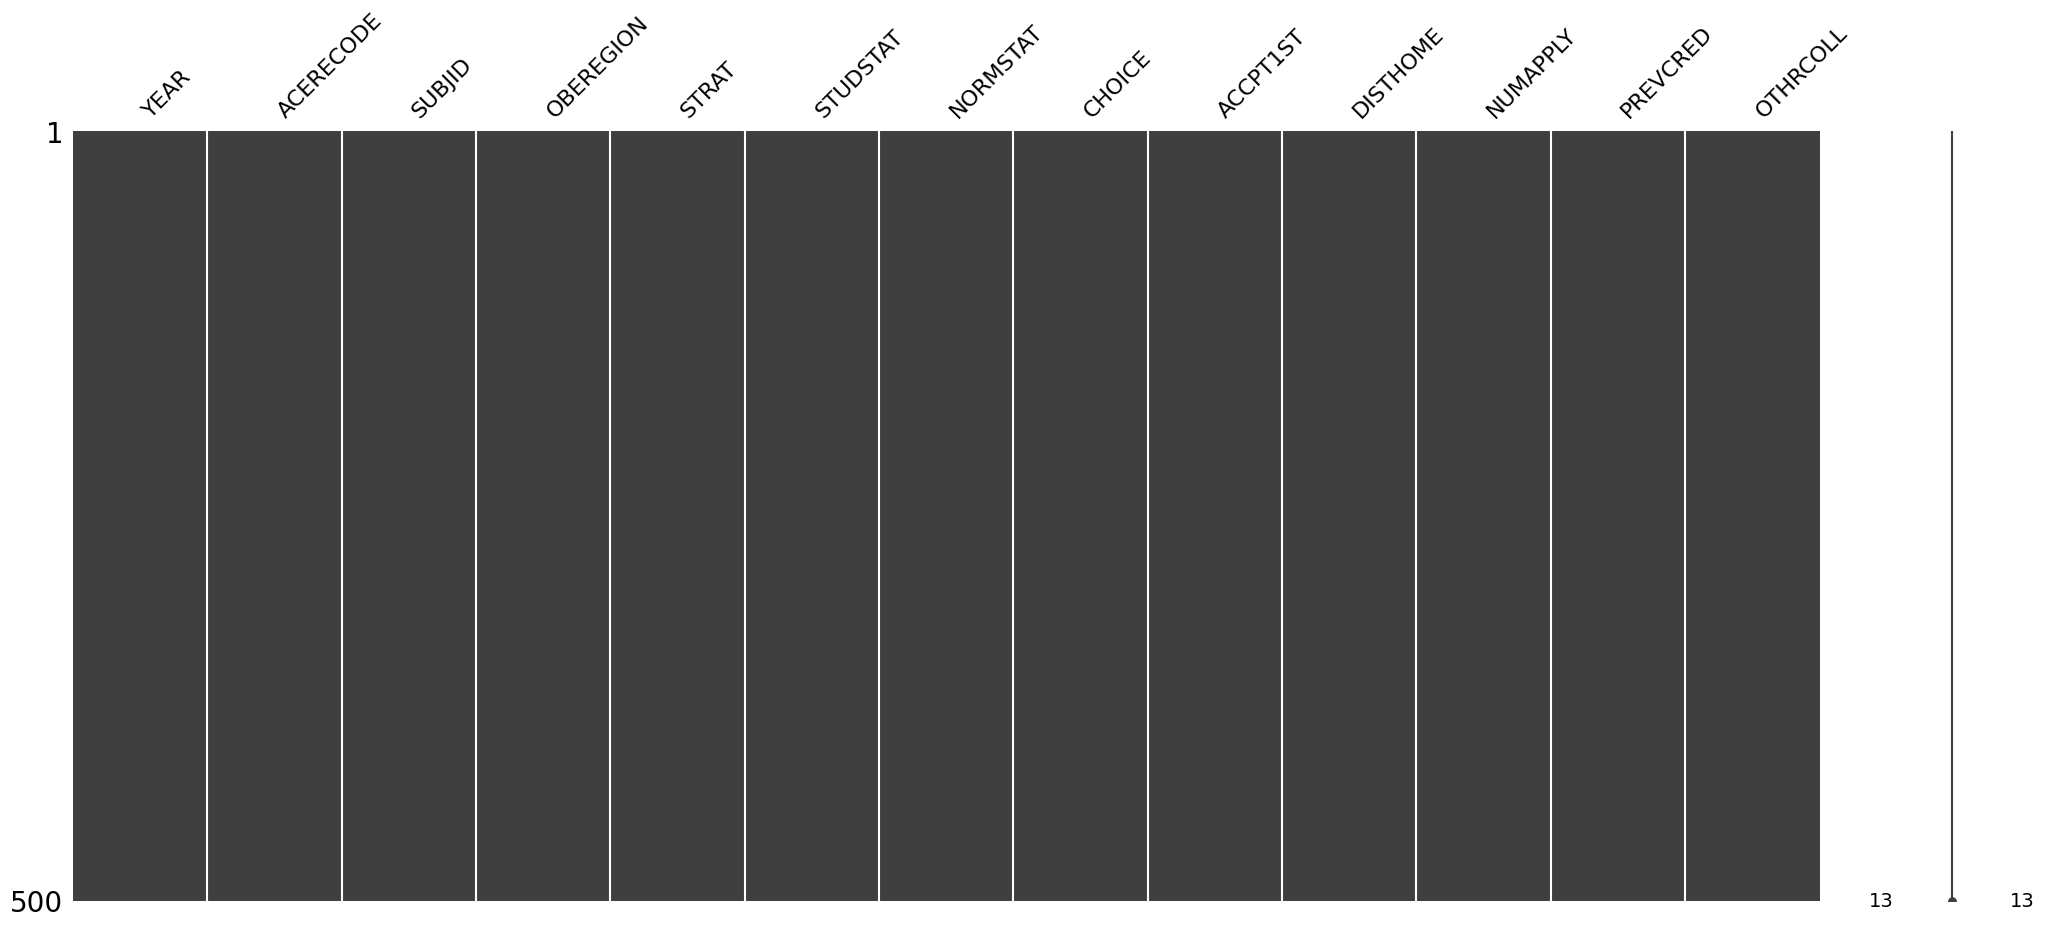

In [16]:
tfs_df = clean_data(tfs_df_raw)

In [17]:
print(tfs_df_raw.shape)
print(tfs_df.shape)

(262433, 111)
(245548, 13)


Again, we're loosing a lot of data to missing values

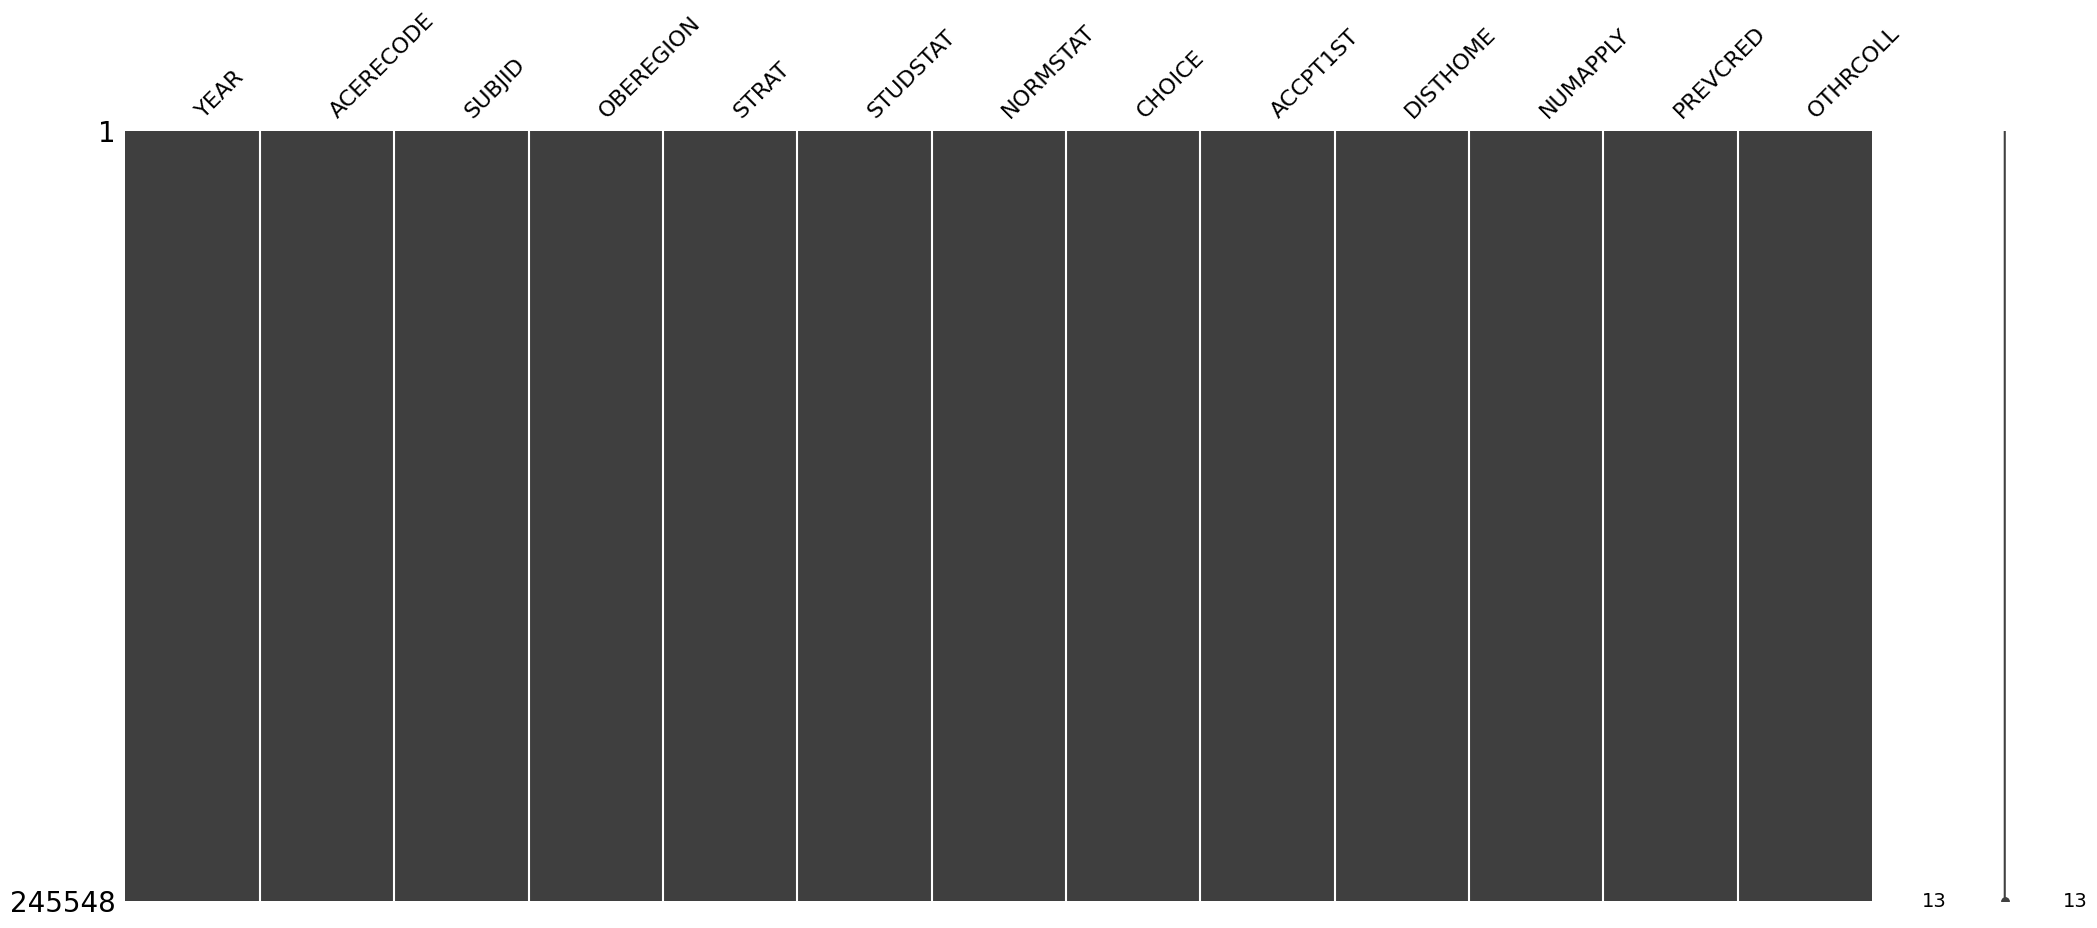

In [ ]:
msno.matrix(tfs_df)
plt.show();

/home/mitch/.local/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2844: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([dvw, 0])


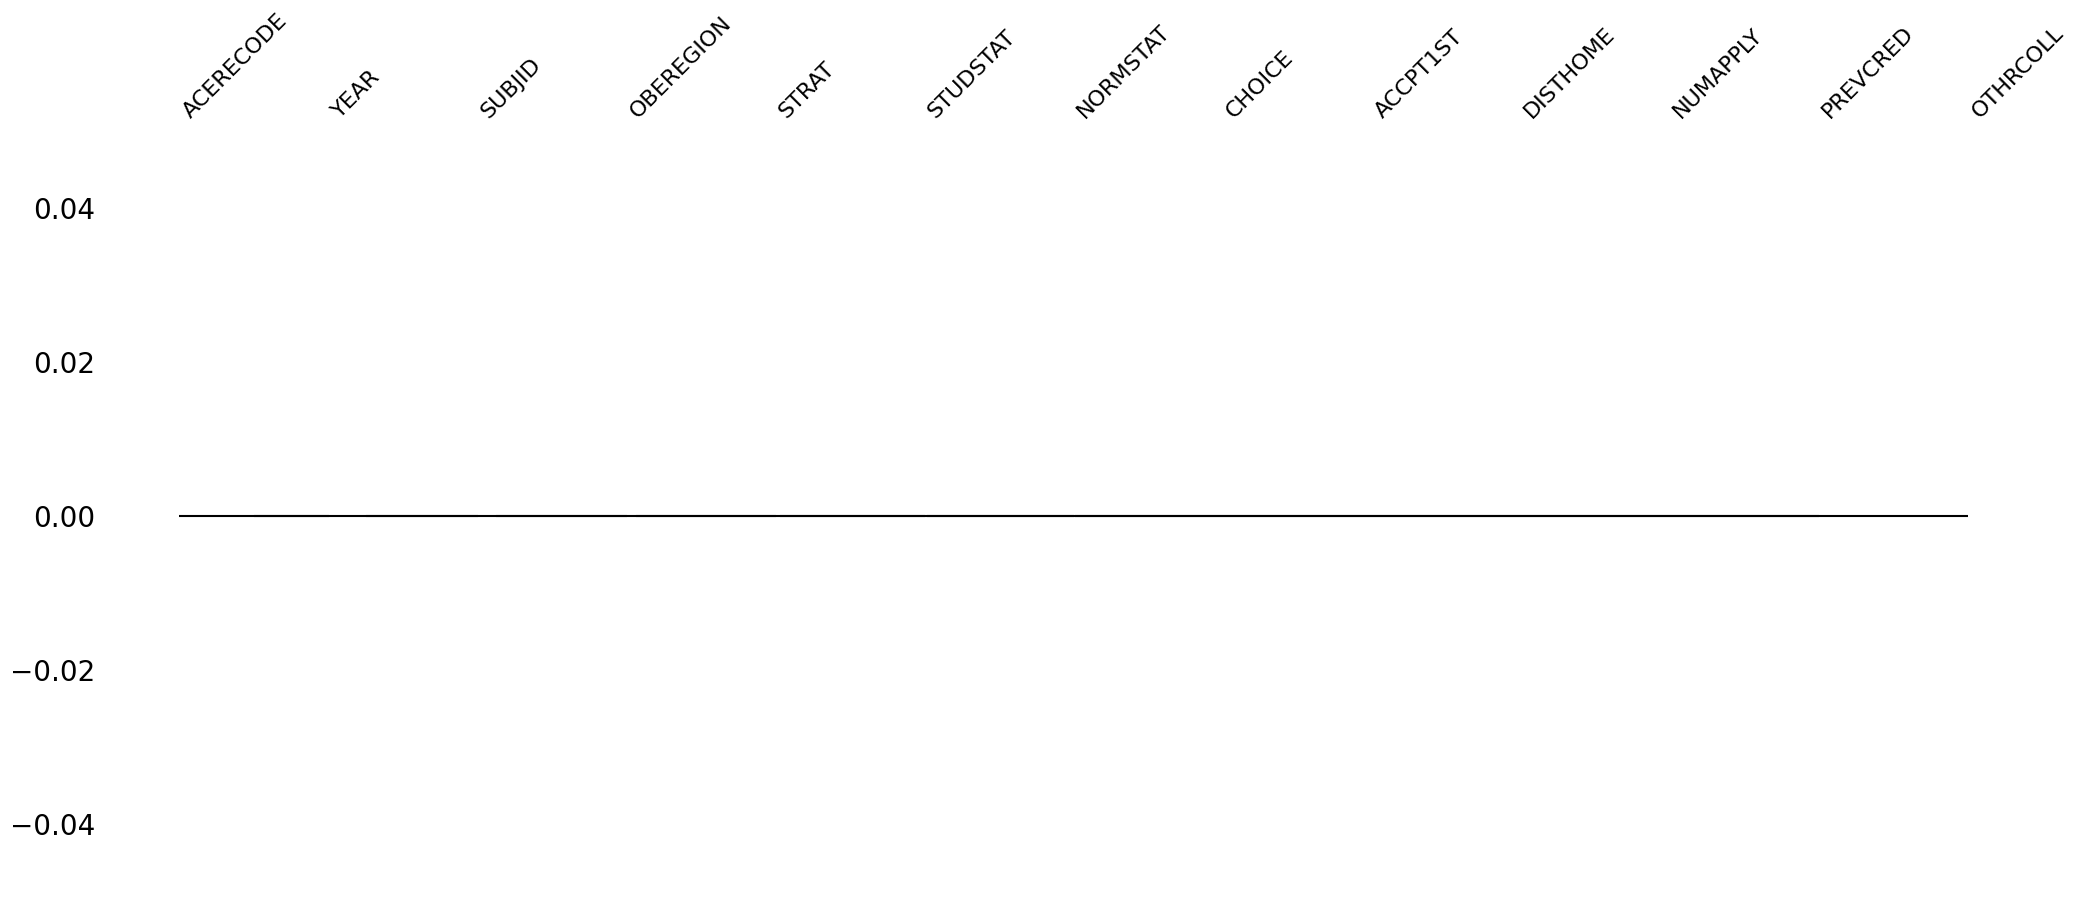

In [18]:
msno.dendrogram(tfs_df.sample(500))
plt.show();

In [ ]:
# Save all the columns to a txt file
with open("../stats/TFS_features.txt", "w") as f:
    for feature in tfs_df.columns:
        f.writelines(f"{feature}\n")

## Merge DataFrames

In [19]:
# Drop duplicate columns
duplicate_cols = [
    'RecodedCollegeI.D.',
    'OBERegion',
    'CIRPStratificationCell',
    'Studentstatus',
    'Normsstatus']

for col in duplicate_cols:
    hs_df.drop(col, inplace=True, axis=1)

dem_df.drop("Surveyyear", inplace=True, axis=1)

In [20]:
print(hs_df.shape)
print(dem_df.shape)
print(tfs_df.shape)

(243305, 69)
(247628, 36)
(245548, 13)


Since high school is the smallest with 243,305 we'll use that as our baseline dataframe so we don't introduce more missing values.

In [21]:
# Save all
merged_df_hs_dem = pd.merge(hs_df, dem_df, how="left", on="SubjectI.D.")

In [22]:
merged_df_hs_dem['SUBJID'] = merged_df_hs_dem['SubjectI.D.']
merged_df_hs_dem.drop('SubjectI.D.', inplace=True, axis=1)

In [23]:
merged_df = pd.merge(merged_df_hs_dem, tfs_df, how='left', on='SUBJID')

<AxesSubplot:>

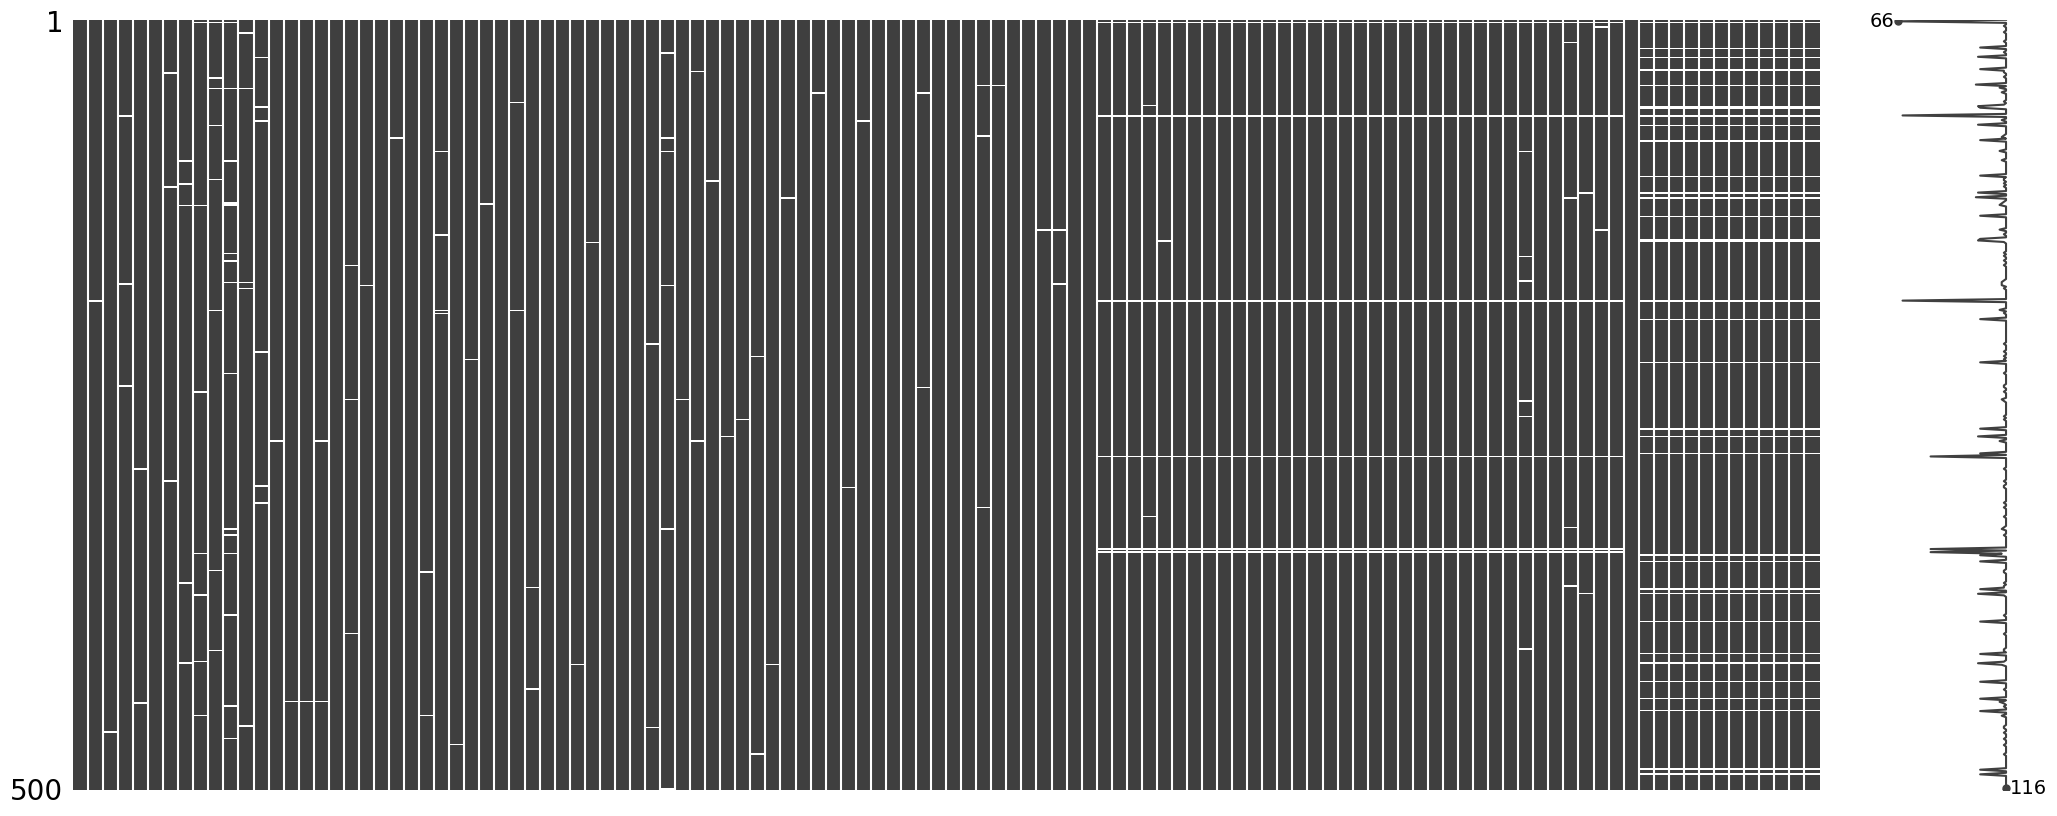

In [24]:
msno.matrix(merged_df.sample(500))

In [25]:
# Check the shape of the merged data
merged_df.shape

(243305, 116)

In [ ]:
# Save the merged data as a csv
# merged_df.to_csv("../data/01-raw/merged_df.csv", index=False)

## CSVs from Chris

Let's take a peek at Chris' csv's.

In [33]:
imputed_df = pd.read_csv("../data/final_frame_imputed.csv")
non_imputed_df = pd.read_csv("../data/final_frame_non_imputed.csv")

In [34]:
imputed_df

,Unnamed: 0,ACERECODE,OBEREGION,STRAT,STUDWGT,REASON05,REASON06,REASON08,REASON07,REASON10,...,Firstgenerationstatusbasedonparent(s)withlessthansomecollege,Fatherscareeraggregated,Motherscareeraggregated,Yourfathersreligiouspreference,Yourmothersreligiouspreference,Areyouaveteran?,SATVerbal,SATMath,SATWriting,ACTComposite
0,0,2192,5.0,34,12.063300,3.0,3.0,2.0,3.0,3.0,...,0,1,1,3,3,0,652.703200,613.233450,624.288946,24.000000
1,5,2192,5.0,34,11.163551,3.0,3.0,2.0,3.0,1.0,...,0,15,15,3,3,0,530.799731,503.714728,517.368543,22.000000
2,17,2192,5.0,34,12.063300,3.0,3.0,3.0,3.0,3.0,...,1,15,10,3,3,0,615.679915,492.632512,693.684890,20.000000
3,19,2192,5.0,34,12.063300,3.0,3.0,3.0,3.0,3.0,...,0,1,15,1,1,0,511.327382,589.750426,524.982445,21.000000
4,23,2192,5.0,34,12.063300,2.0,2.0,2.0,2.0,2.0,...,0,17,19,3,3,0,387.089957,409.247586,314.628895,19.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98577,262219,439,2.0,13,11.945652,3.0,3.0,3.0,3.0,2.0,...,1,15,15,2,2,0,430.802224,464.955360,431.296085,21.000000
98578,262220,439,2.0,13,9.875781,3.0,3.0,3.0,3.0,3.0,...,0,15,15,3,3,0,540.000000,630.000000,540.000000,24.614693
98579,262221,439,2.0,13,11.945652,3.0,3.0,3.0,3.0,3.0,...,1,15,15,3,3,0,517.074879,643.295464,534.182373,25.435717
98580,262222,439,2.0,13,9.875781,3.0,3.0,3.0,3.0,3.0,...,0,11,2,3,3,0,430.000000,570.000000,420.000000,23.302451


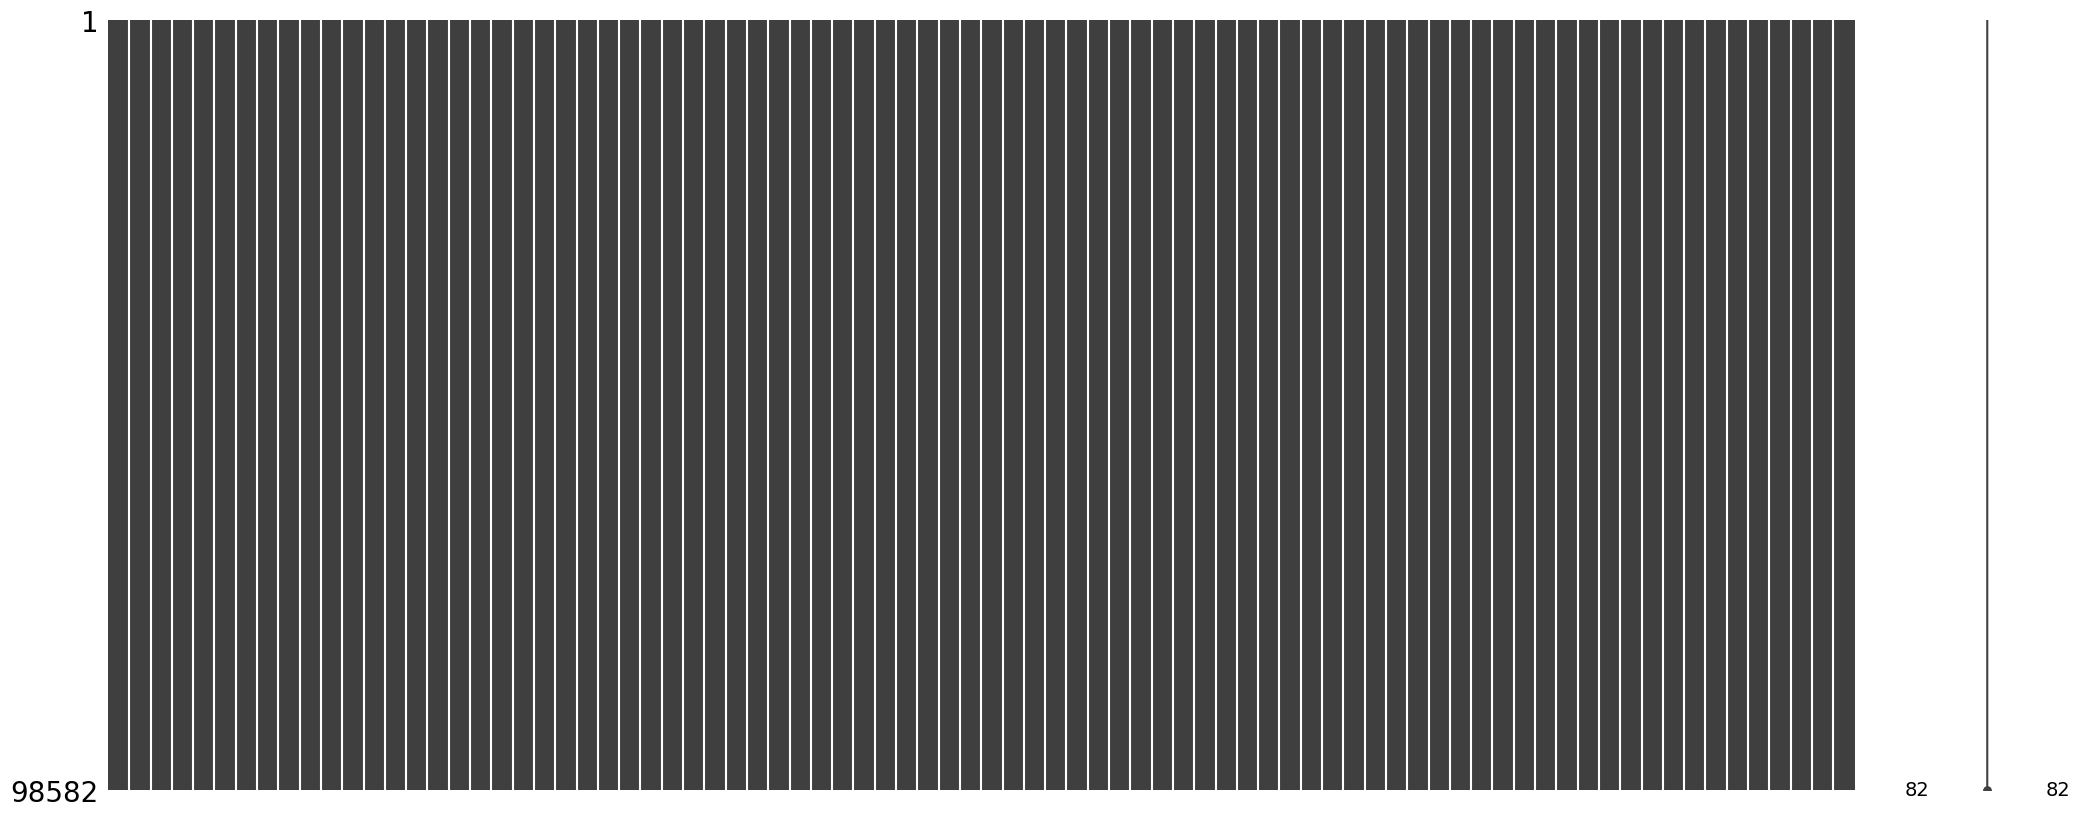

In [28]:
msno.matrix(imputed_df);

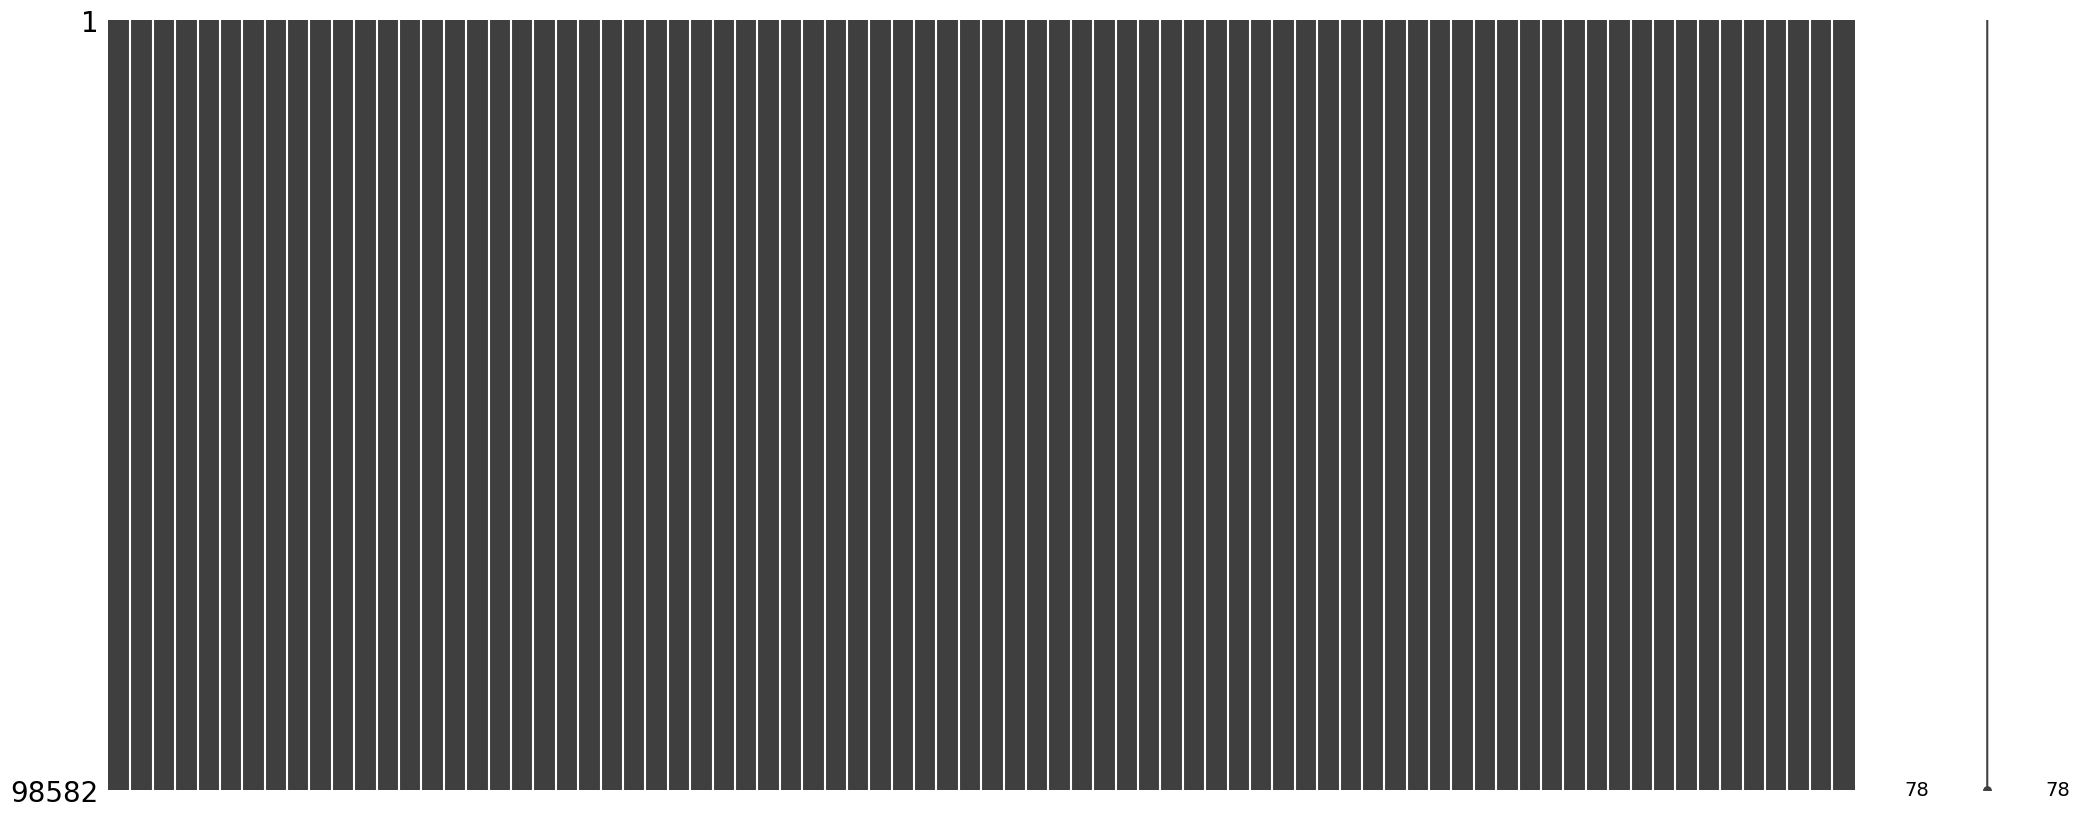

In [32]:
msno.matrix(non_imputed_df);